# Modélisation des séries temporelles avec LSTM : Cas pratique et implémentation

## 1. Introduction
Ce tutorial s'adresse aux debutants qui veulent monter en competence sur l'etude et la visualisation des données sequentielles. Nous allons utiliser des approches statistiques pour determiner quels modéle est mieu adapter au traitement du jeu de donnees. Dans ce tutoriels, nous apprenons les models ARIMA, SARIMA, SARIMAX et LSTM et comprendre leurs differences et leurs utilisations. 
nous analysons le dataset [Household Electric Power Consumption](https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set/data).

## 2. Exploration des Données (EDA)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
print("The current repertory :", os.getcwd())

The current repertory : /home/kd/Desktop/DL_TimeSeries/tests


In [3]:
file_path = '../data/individual+household+electric+power+consumption/household_power_consumption.txt'
if os.path.exists(file_path):
    print("File found!")
else: 
    print("File NOT found, Check the path please!")

File found!


In [4]:
if os.path.exists(file_path):
    print("File found!")
    df = pd.read_csv(file_path, sep=';', 
                     low_memory=False, 
                     na_values=['nan','?'])
    
    # Combine 'Date' and 'Time' columns and convert to datetime
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
    df.set_index('datetime', inplace=True)
    
    # Drop the original 'Date' and 'Time' columns
    df.drop(columns=['Date', 'Time'], inplace=True)
    
    print("Data loaded and datetime parsed successfully!")
else: 
    print("File NOT found, Check the path please!")

File found!
Data loaded and datetime parsed successfully!


In [6]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [8]:
df.shape

(2075259, 7)

In [9]:
# Statistiques Deescriptives
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


L’analyse statistique descriptive nous donne un aperçu des valeurs centrales, des dispersions et des extrêmes pour chaque variable du dataset Household Power Consumption.
- ***Global Active Power***
    - Moyenne (mean) : 1.09 kW → La consommation électrique moyenne est d'environ 1 kW.
    - Min & Max : 0.076 kW à 11.12 kW → La consommation varie fortement, avec des pics élevés.
    - Écart-type (std) : 1.06 kW → Forte dispersion, ce qui indique que la consommation fluctue beaucoup.
    - Distribution : La médiane (50%) est 0.6 kW, ce qui montre que la majorité des valeurs sont inférieures à la moyenne (distribution asymétrique à droite).
    - Valeurs extrêmes (outliers) : Des pics jusqu'à 11.12 kW indiquent des périodes de consommation très élevée
- ***Global Reactive Power***
    - Moyenne : 0.12 kW → Relativement faible, ce qui est normal car la puissance réactive est l’énergie non consommée (pertes).
    - Écart-type : 0.11 kW → Variation significative, bien que les valeurs restent faibles.
    - Max : 1.39 kW → Certaines périodes présentent des pertes électriques importantes.
- ***Voltage***
    - Moyenne : 240.8 V, avec un écart-type de 3.2 V → La tension est stable, centrée autour de la valeur standard de 240 V.
    - Min & Max : 223.2 V à 254.1 V → Quelques fluctuations, mais dans une plage acceptable.
- ***Global Intensity***
    - Moyenne : 4.62 A, avec une médiane de 2.6 A → L’intensité consommée est généralement faible.
    - Max : 48.4 A → Certains appareils gourmands en énergie peuvent provoquer des pics.

In [10]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

### Traitement des valeurs manquantes « nan » avec une statistique de test

In [11]:
# Vérification des Valeurs Manquantes
missing_values = df.isnull().sum()
print(missing_values)

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


In [12]:
# Récupérer les indices des colonnes avec des valeurs manquantes
droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [13]:
# Remplacer les valeurs manquantes par la moyenne de la colonne

for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [14]:
#  Vérification des valeurs manquantes après le remplissage
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

array([[<Axes: title={'center': 'Global_active_power'}>,
        <Axes: title={'center': 'Global_reactive_power'}>,
        <Axes: title={'center': 'Voltage'}>],
       [<Axes: title={'center': 'Global_intensity'}>,
        <Axes: title={'center': 'Sub_metering_1'}>,
        <Axes: title={'center': 'Sub_metering_2'}>],
       [<Axes: title={'center': 'Sub_metering_3'}>, <Axes: >, <Axes: >]],
      dtype=object)

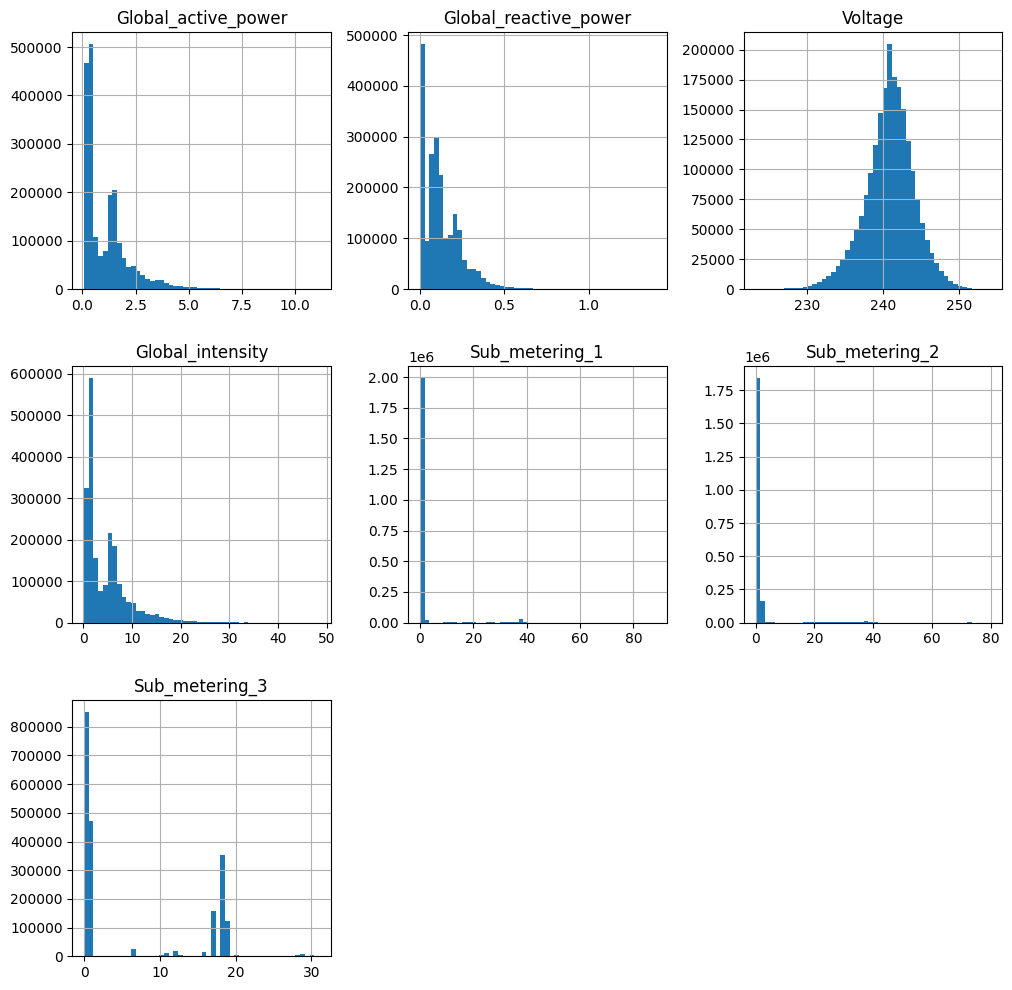

In [15]:
# Visualisation des Distributions
df[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].hist(bins=50, figsize=(12, 12))

Le graph ci-dessus permet d'examiner la distribution des différentes variables du dataset Household Power Consumption.

- ***Global Active Power*** est fortement asymétrique à droite  ce qui indique que la plupart des valeurs sont inférieur à (< 2 kW), mais qu’il existe des valeurs plus élevées jusqu’à environ 10 kW.
    - On observe deux pics distincts autour de 0.5 kW et 1.5 kW, ce qui peut suggérer des cycles d'utilisation d'appareils électriques.

- ***Voltage***  suit une courbe normale (distribution gaussienne) centrée autour de 240 V, ce qui est cohérent avec une alimentation électrique standard.
    - Les fluctuations sont comprises entre 225 V et 255 V.
    - La présence d'une symétrie suggère que la tension électrique reste stable la plupart du temps.

- ***Global Intensity*** suit une distribution similaire à la puissance active globale, car elle est directement liée à la consommation électrique (puissance = tension × intensité).
    - La majorité des valeurs sont faibles (< 10 A), mais il existe quelques valeurs plus élevées allant jusqu'à 50 A.
- ***Sub_metering_1 et Sub_metering_2*** : On obseve que la majorité des valeurs sont proches de 0, indiquant que cette sous-mesure ne capture de l’énergie que dans certaines périodes spécifiques.
- ***Sub_metering_3*** On observe trois pics distincts ce qui peut être lié à des variations de consommation en fonction des saisons.


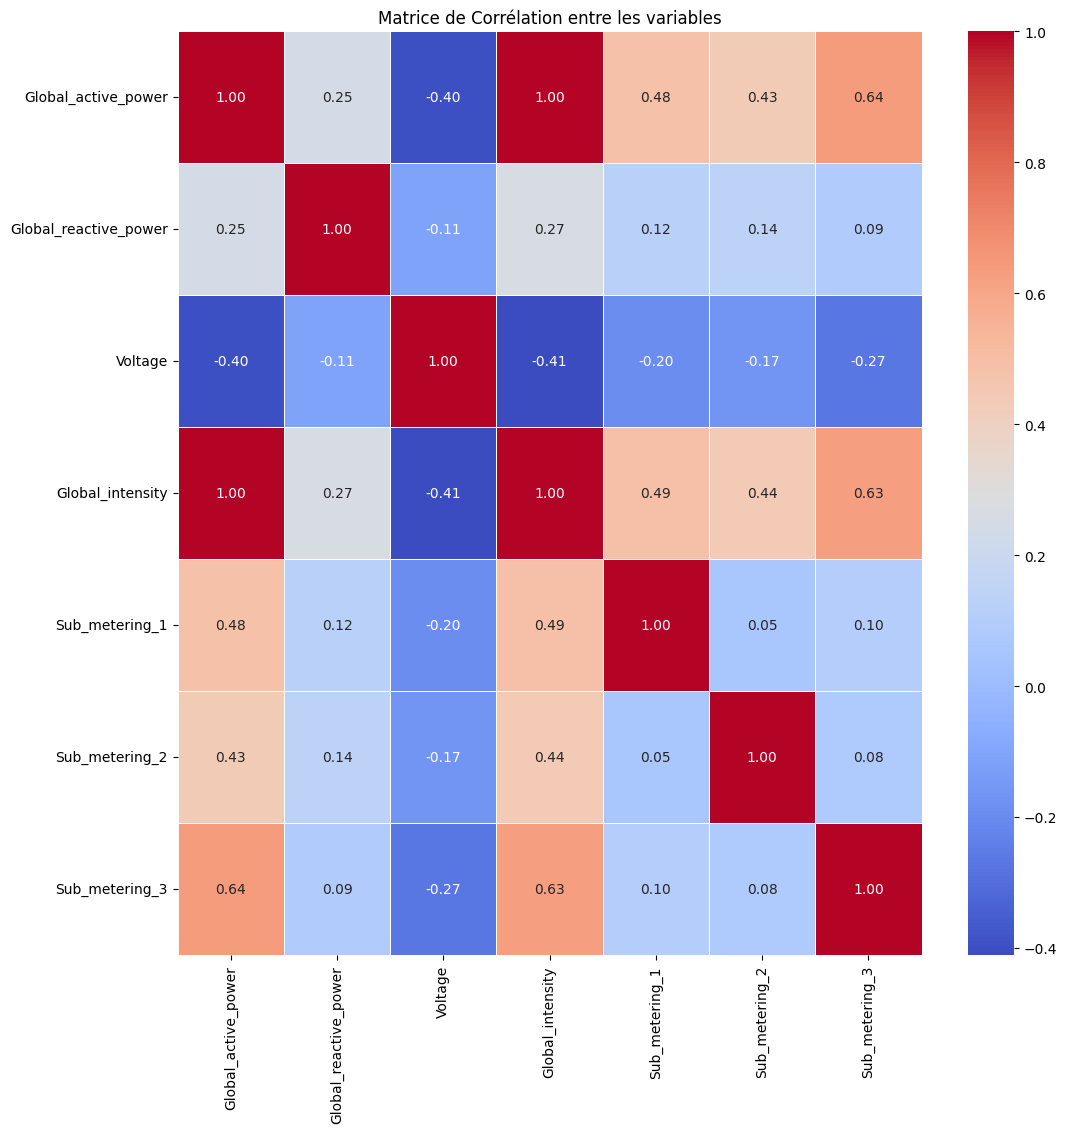

In [16]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation entre les variables")
plt.show()

Ce heatmap de corrélation permet de visualiser les relations entre les variables du dataset. Cette matrice nous aide à identifier les variables pertinentes pour prédire la consommation.
- ***Variables fortement corrélées***
    - **Global_active_power et Global_intensity (+1.00)**: l'intensité électrique est directement liée à la puissance consommée.
    - **Global_active_power et Sub_metering_3 (+0.64)**: la consommation mesurée par le compteur 3 contribue fortement à la consommation totale.
    - **Global_intensity et Sub_metering_3 (+0.63)**: Une hausse de l'intensité est souvent associée à une augmentation de la consommation de ce compteur.
- ***Variables avec une corrélation négative***
    - **Voltage et Global_active_power (-0.40)** : lorsque la puissance consommée augmente, la tension a tendance à baisser.
    - **Voltage et Global_intensity (-0.41)**: plus l’intensité augmente, plus la tension baisse, ce qui peut être dû à une chute de tension provoquée par une forte demande.
- ***Variables faiblement corrélées***
    - **Global_reactive_power** a une faible corrélation avec la puissance active (0.25).
    - **L'heure (hour)** n'a qu'une légère influence sur la consommation (0.28 avec Global_active_power).
    - **Les Sub_metering 1 & 2** sont peu corrélés aux autres variables, suggérant qu’ils mesurent des équipements spécifiques.
    
La tension et l’intensité influencent directement la puissance consommée.
Les sous-compteurs ont un impact inégal, suggérant des usages différents.


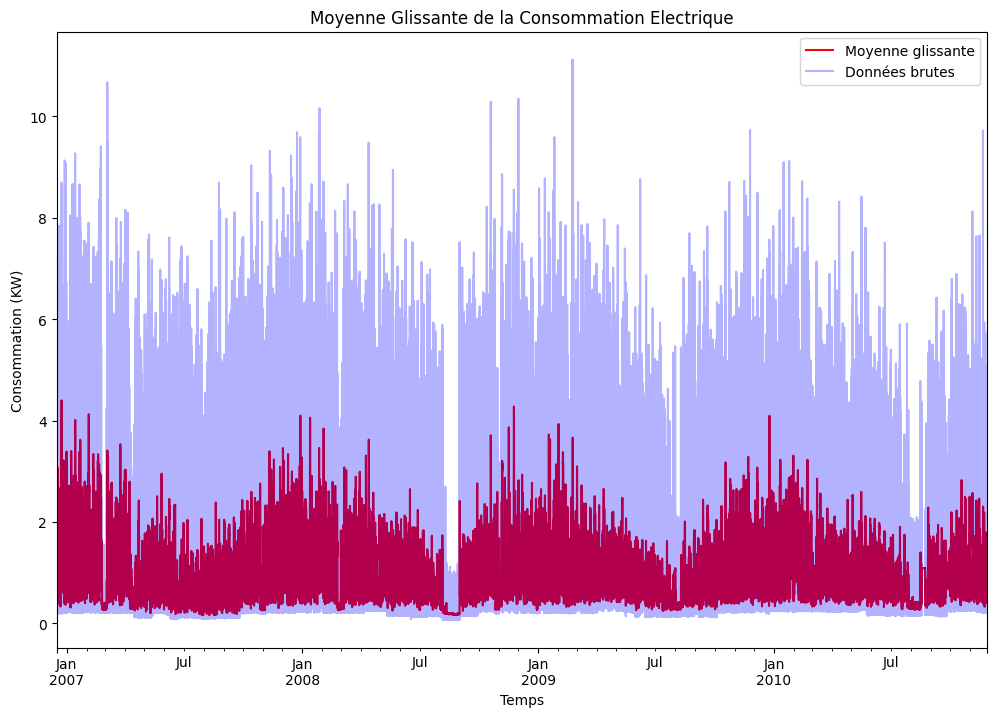

In [17]:
plt.figure(figsize=(12, 8))
df['Global_active_power'].rolling(window=500).mean().plot(label='Moyenne glissante', color='red')
df['Global_active_power'].plot(alpha=0.3, label="Données brutes", color='blue')

plt.legend()
plt.title("Moyenne Glissante de la Consommation Electrique")
plt.xlabel("Temps")
plt.ylabel("Consommation (KW)")
plt.show()


Nous essayons d'analyser les tendances de consommation électrique au fil du temps en utilisant une moyenne glissante.
- ***Données brutes (en bleu clair)***:
    - La série temporelle montre une forte variabilité avec des pics fréquents.
    - On observe des périodes de consommation plus élevée que d'autres.
    - Des variations saisonnières peuvent être identifiées, avec des cycles récurrents.
- ***Moyenne glissante (en rouge foncé)***:
    - Elle permet de lisser les fluctuations en révélant la tendance générale de la consommation.
    - On remarque une tendance à la hausse et des variations cycliques
    - La consommation semble légèrement plus élevée en hiver.


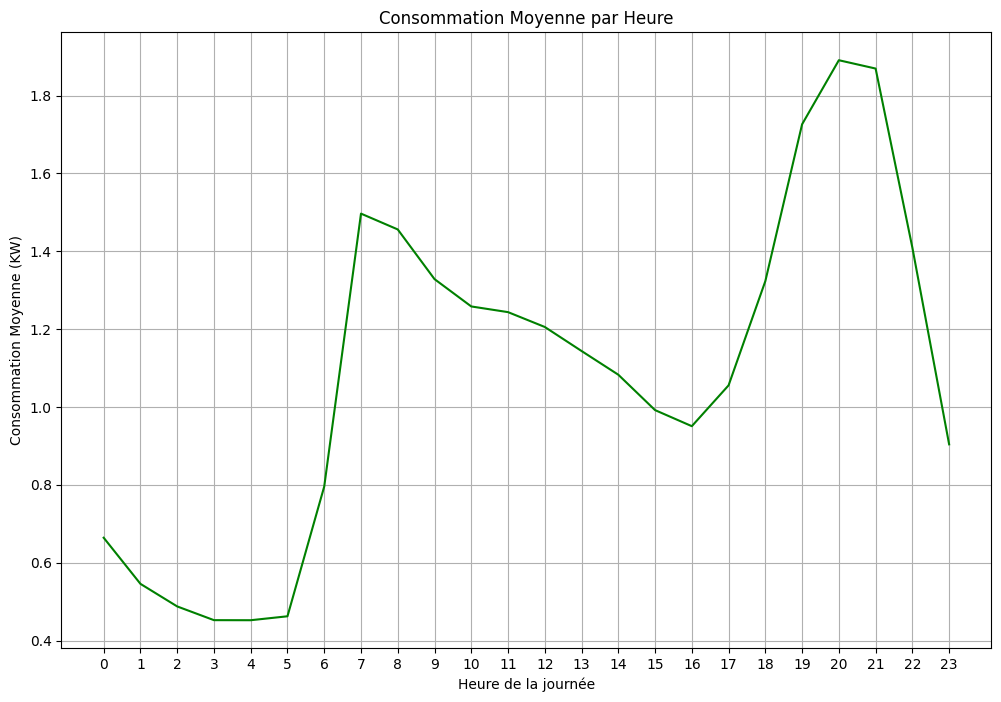

In [18]:
# Saisonnière - Moyenne par Heure
df['hour'] = df.index.hour
hourly_avg = df.groupby('hour')['Global_active_power'].mean()

plt.figure(figsize=(12, 8))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values, markers='o', color='green')
plt.title("Consommation Moyenne par Heure")
plt.xlabel("Heure de la journée")
plt.ylabel("Consommation Moyenne (KW)")
plt.xticks(range(0, 24))
plt.grid()
plt.show()


Ce graphique montre la moyenne de la consommation électrique en fonction de l’heure de la journée.
- ***Consommation basse pendant la nuit (0h - 5h)***:
    - La consommation commence faible aux alentours de 0.6 kW.
    - Elle atteint son point le plus bas entre 3h et 5h (environ 0.4 kW), ce qui est cohérent avec le fait que la plupart des appareils sont éteints durant cette période.
- ***Forte augmentation entre 6h et 8h*** :
    - Vers 6h, on observe un pic brutal, atteignant environ 1.5 kW à 7h - 8h. Cela correspond aux activités du matin : éclairage, préparation du petit déjeuner, chauffage, électroménagers.
- ***Stabilisation en journée (10h - 16h)*** :
La consommation baisse légèrement après 8h et atteint 0.9 kW au alentours de 16h pendant la journée.
Cette stabilité peut être due à des appareils en veille ou au travail à domicile.
- ***Nouveau pic en soirée (18h - 21h)*** :
    - À 18h, la consommation commence à remonter fortement. Elle culmine entre 20h et 21h avec une valeur proche de 1.9 kW.
    Ce pic est probablement lié aux activités du soir : retour à la maison, préparation du dîner, télévision, chauffage, éclairage.

- ***Forte baisse après 22h*** :
La consommation chute après 22h, indiquant une réduction des activités domestiques avant la nuit.


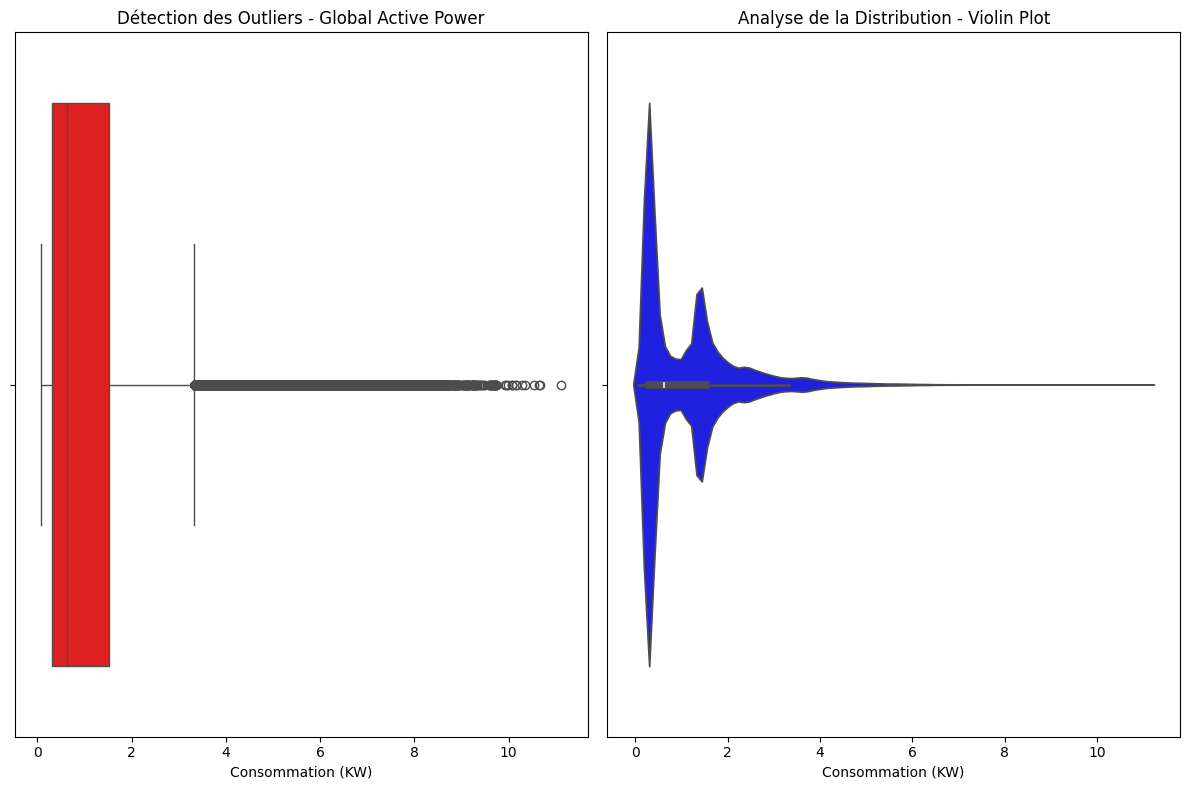

In [19]:

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
# Boxplot pour la détection des outliers
sns.boxplot(x=df['Global_active_power'], color='red', ax=axes[0])
axes[0].set_title("Détection des Outliers - Global Active Power")
axes[0].set_xlabel("Consommation (KW)")

# Violin Plot pour l'analyse de la distribution
sns.violinplot(x=df['Global_active_power'], color='blue', ax=axes[1])
axes[1].set_title("Analyse de la Distribution - Violin Plot")
axes[1].set_xlabel("Consommation (KW)")

plt.tight_layout()
plt.show()


Le graphique ci-dessus affiche à gauche un boxplot et à droite un violin plot pour analyser la distribution et détecter les valeurs aberrantes de la consommation électrique (Global Active Power).
- ***Boxplot (Gauche)***
    - Le rectangle rouge représente l’intervalle interquartile (IQR), qui couvre 50% des valeurs.
    - La ligne centrale indique la médiane, et les "moustaches" étendent les données jusqu'à 1.5 fois l'IQR.
    - Les points au-delà des moustaches sont considérés comme des outliers (valeurs extrêmes).
    - Il semble y avoir de nombreuses valeurs extrêmes au-dessus du maximum attendu.
- ***Violin Plot (Droite)***
    - Il montre une version lissée de l’histogramme pour visualiser la densité des valeurs.
    On remarque une concentration des données autour des faibles valeurs de consommation entre 0 et 2 kW.
    Une forte densité autour de 1 kW, ce qui signifie que cette consommation est courante
  
Contrairement au boxplot, le violin plot montre comment les valeurs sont réparties.

## 2. Analyse statistique

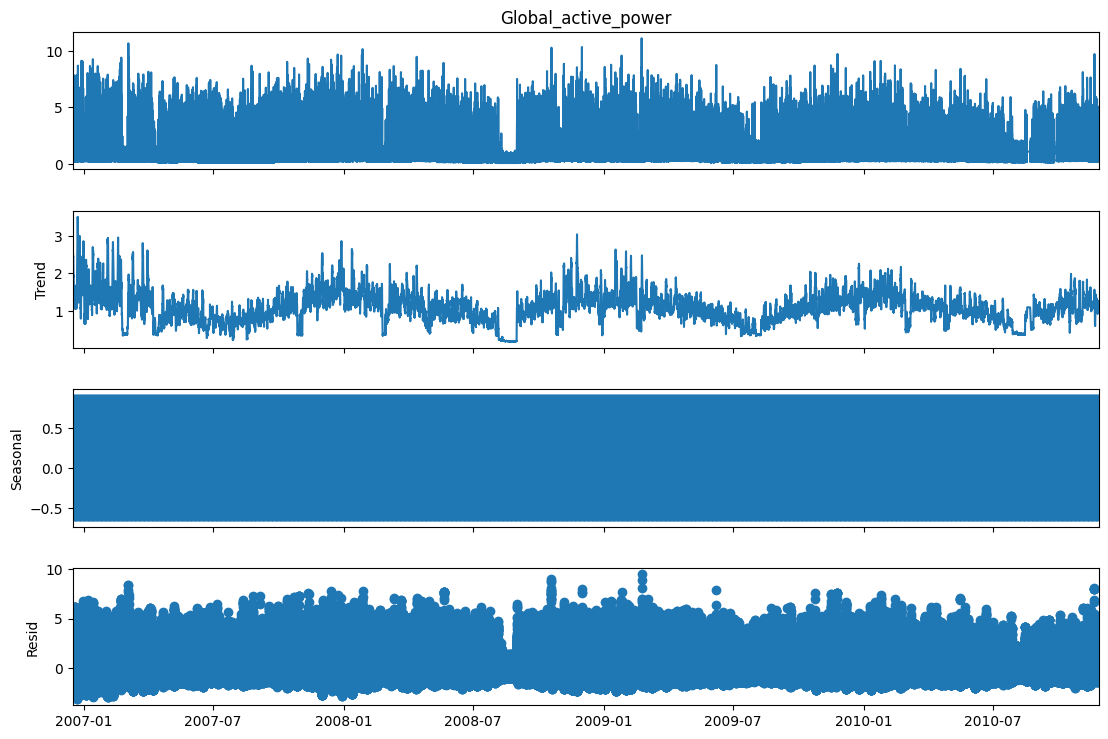

In [20]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Global_active_power'], period=1440)  # 1440 minutes = 1 jour

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()


Le graphique affiche la décomposition saisonnière de la série temporelle Global_active_power. Nous allons nous interressée sur une periode données.

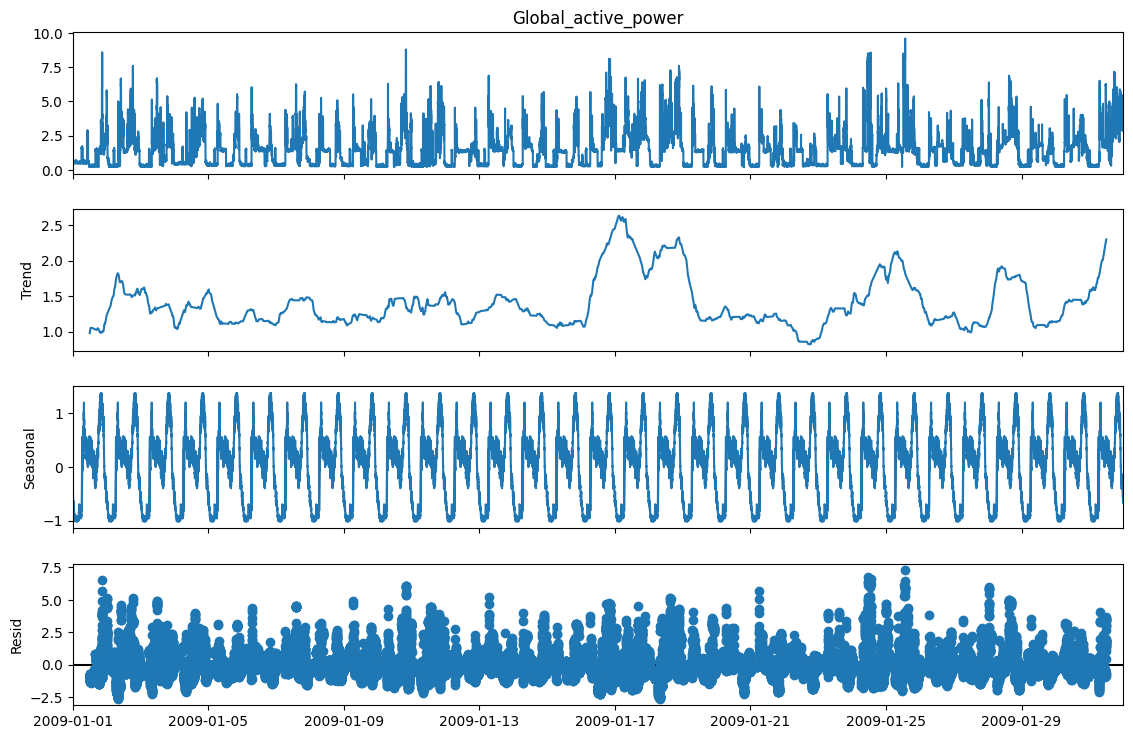

In [21]:
df_sample = df.loc['2009-01-01':'2009-01-31']
decomposition = seasonal_decompose(df_sample['Global_active_power'], period=1440) 
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()


Ce graphique représente la décomposition de la série temporelle pour la consommation électrique (Global_active_power) sur un mois complet en janvier 2009.
- ***Série Originale (Global_active_power)***
    - On observe d’importantes variations de la consommation électrique.
    - Les pics sont réguliers, souvent associés aux moments de forte activité dans la journée (ex. matin et soir).
    - On remarque aussi des périodes de consommation très faible, probablement la nuit.
- ***Tendance (Trend)***
    - La tendance générale montre une évolution progressive de la consommation.
    Il y a une hausse autour du 15 janvier et une diminution est visible autour du 19 janvier.
- ***Saisonnalité (Seasonal)***
    - La saisonnalité est bien marquée avec un cycle de 24 heures.
    - Cela correspond aux habitudes quotidiennes des utilisateurs : forte consommation le matin et le soir.
    - Ce comportement répétitif confirme l'influence des rythmes de vie.
- ***Résidus (Resid)***
    - Ces résidus représentent la partie imprévisible de la série.
    - On observe des variations importantes, ce qui suggère des anomalies ponctuelles.
    - Ces pics aléatoires pourraient être causés par des événements exceptionnels (ex. équipements activés de manière irrégulière).

- ***Test de Stationnarité Dickey-Fuller (adfuller)***
Le test de Dickey-Fuller Augmenté (ADF) vérifie si une série temporelle est stationnaire ou non stationnaire.

    - **Hypothèse nulle (H0)** : La série a une racine unitaire, donc elle n'est pas stationnaire (elle suit une tendance).
    - **Hypothèse alternative (H1)** : La série est stationnaire

- ***Règle de Décision***
    - Si p-value < 0.05 → Rejet de H0 → La série est stationnaire
    - Si p-value ≥ 0.05 → On ne rejette pas H0 → La série n'est pas stationnaire

In [22]:
from statsmodels.tsa.stattools import adfuller
sample_size = 100_000  # Prendre un sous-échantillon de 100 000 points
df_sample = df['Global_active_power'].iloc[:sample_size]
result = adfuller(df_sample)
print(f"p-value: {result[1]}")

p-value: 3.472902552115768e-29


Une p-value très faible (3.52 × 10⁻²⁹, soit pratiquement 0) indique que l'hypothèse nulle (H0) est rejetée donc la série Global_active_power est stationnaire ! 

- Une série stationnaire a :

    - Une moyenne constante au fil du temps.
    - Une variance constante.
    - Une autocorrélation constante.

Si une série est stationnaire, elle est plus facile à modéliser avec des méthodes comme ARIMA, LSTM, etc

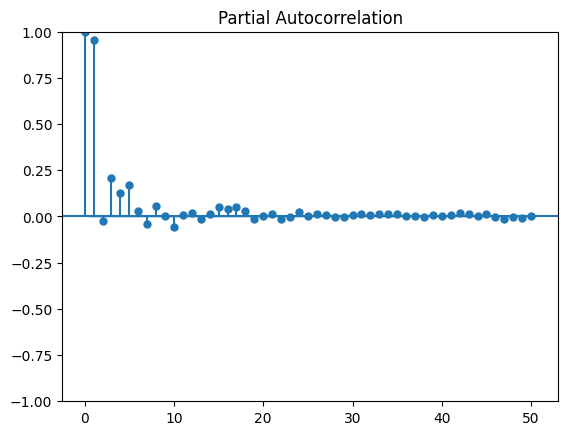

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_sample, lags=50)
plt.show()

## **Interprétation du Graphique : Fonction d'Autocorrélation Partielle (PACF)**

Ce graphique représente la **fonction d'autocorrélation partielle (PACF)**, qui **mesure la corrélation directe entre une valeur et ses lags**, après avoir **éliminé l'effet des valeurs intermédiaires**.

- ***Analyse du Graphique PACF***
    - **À lag = 0**, la corrélation est toujours **1.0** (**normal**).  
    - **Forte corrélation à lag = 1** (~0.8) → **Indique que la valeur actuelle dépend fortement de la valeur précédente**.  
    - **Corrélations significatives jusqu'à lag ≈ 5**, puis **elles deviennent négligeables**.  
    - **Diminution rapide vers zéro** → Cela signifie que **les lags après 5-7 n'ont presque plus d'impact sur la valeur actuelle**.  

ACF:  [ 1.          0.95402759  0.90788435 ... -0.08225573 -0.08191912
 -0.08139527]


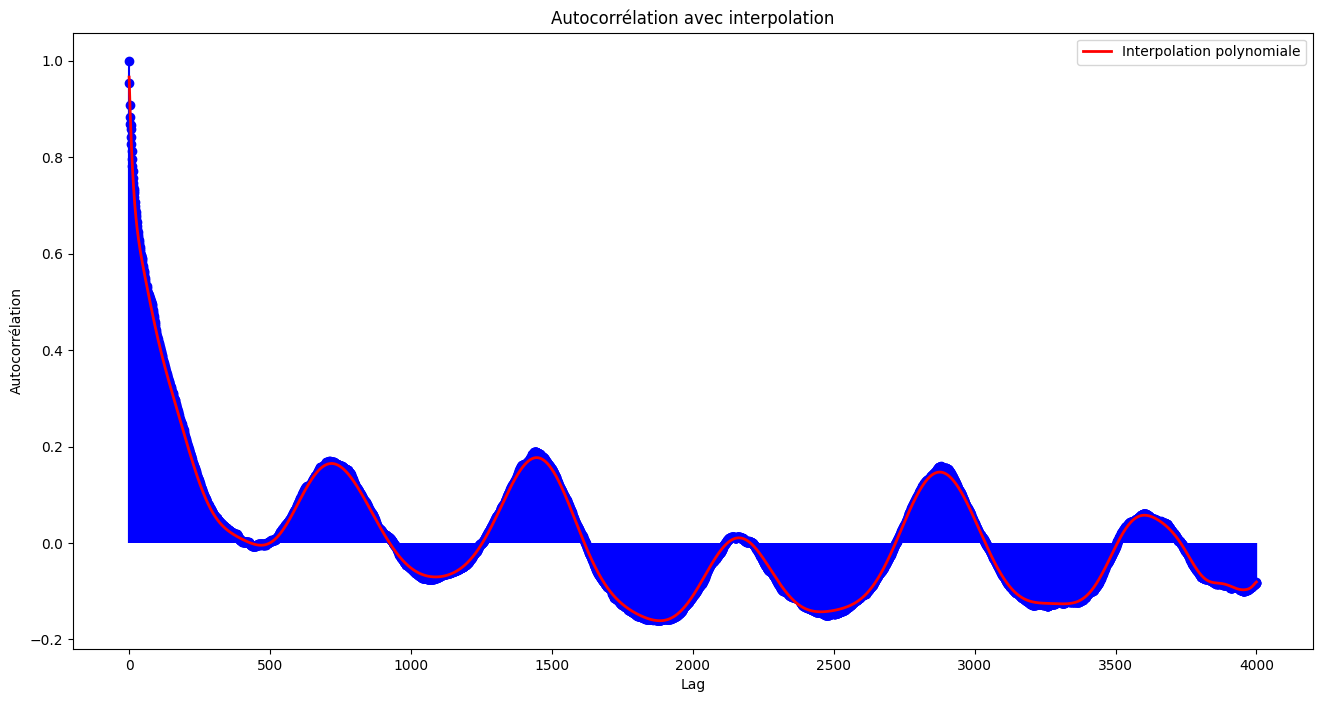

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Calculer l'ACF
from statsmodels.tsa.stattools import acf
from numpy.polynomial.chebyshev import Chebyshev

lags = 4000 # Nombre de lags à afficher
acf_values = acf(df_sample, nlags=lags)

print("ACF: ", acf_values)

# Interpolation avec une régression polynomiale
x = np.arange(len(acf_values))

cheb_poly = Chebyshev.fit(x, acf_values, deg=40)  # Ajustement avec Chebyshev
poly_fit = cheb_poly(x) 

# Tracer l'ACF et l'interpolation
plt.figure(figsize=(16,8))
plt.stem(x, acf_values, linefmt='b-', markerfmt='bo', basefmt=" ")
plt.plot(x, poly_fit, 'r-', label="Interpolation polynomiale", linewidth=2)
plt.xlabel("Lag")
plt.ylabel("Autocorrélation")
plt.title("Autocorrélation avec interpolation")
plt.legend()
plt.show()


### **Analyse du Graphique : Autocorrélation et Interpolation Polynomiale**

L'image représente **l'autocorrélation des données avec une interpolation polynomiale**, illustrant la **structure des dépendances temporelles** à différents **lags**.



- ***Structure d'Autocorrélation***
    - **Une forte autocorrélation initiale** qui **décroît progressivement**.  
    - **Des oscillations périodiques** qui **suggèrent la présence d’une saisonnalité**.  
    - **La récurrence des pics à intervalles fixes** indique **une périodicité forte**, typique de **séries temporelles saisonnières**.

- ***Interpolation Polynomiale (Courbe Rouge)***
    - **L’ajustement suit bien la tendance globale des points bleus**.  
    - **La fonction polynomiale tente de lisser les fluctuations de l'autocorrélation**.  
    - **Utile pour identifier les tendances dominantes**, mais peut **ne pas refléter parfaitement les détails fins des cycles courts**.

- **Cycles Observés**
    - **Les pics à intervalles réguliers indiquent une structure saisonnière forte**.  
    - **La répétition des motifs confirme l’existence de périodicité**.  
    
- **Les modèles SARIMA sont bien adaptés** pour **capturer ces structures répétitives**.

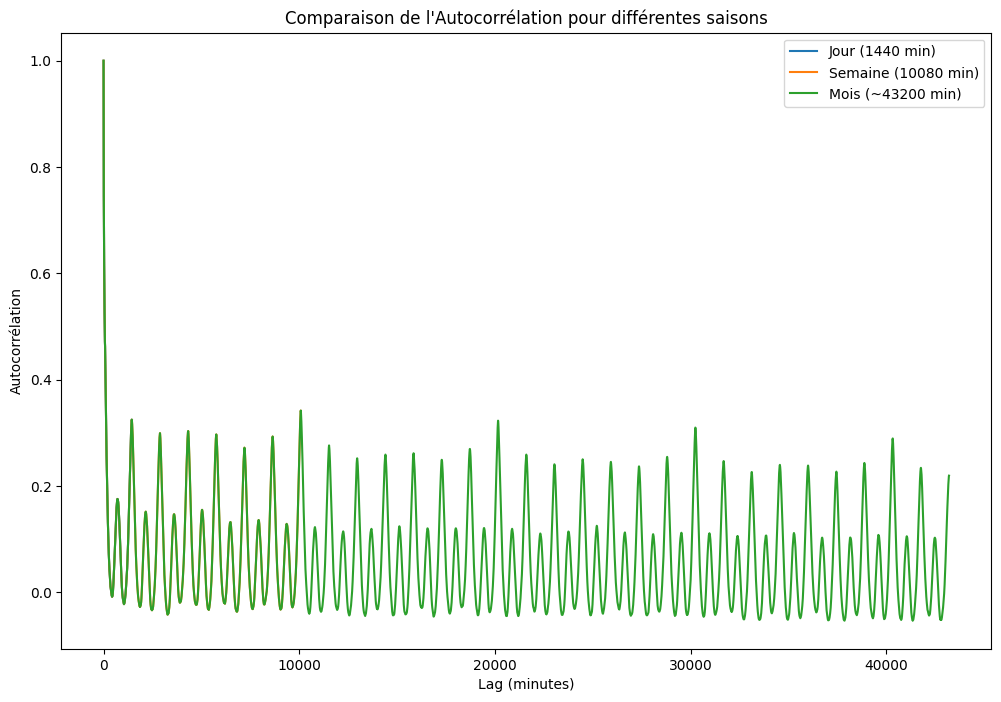

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Définition des périodes
lags_dict = {
    "Jour (1440 min)": 1440,
    "Semaine (10080 min)": 10080,
    "Mois (~43200 min)": 43200
}

plt.figure(figsize=(12, 8))

# Calcul et affichage de l'ACF pour chaque période
for label, nlags in lags_dict.items():
    acf_values = acf(df['Global_active_power'], nlags=nlags)
    x = np.arange(len(acf_values))
    plt.plot(x, acf_values, label=label)

plt.xlabel("Lag (minutes)")
plt.ylabel("Autocorrélation")
plt.title("Comparaison de l'Autocorrélation pour différentes saisons")
plt.legend()
plt.show()


### **Analyse du Graphique : Comparaison des Autocorrélations pour Différentes Périodes**

La figure ci-dessus représente **une comparaison des autocorrélations** pour différentes **périodes temporelles** (**jour, semaine, mois**) en fonction du **lag en minutes**.

- ***Saisonnalité Claire et Répétitive***
    - **Présence de pics d’autocorrélation à intervalles réguliers**, confirmant **la répétition des cycles temporels**.  
    - **Les pics indiquent que la consommation suit un motif récurrent** sur des périodes - **journalières, hebdomadaires et mensuelles**.  

Le graphique confirme une structure saisonnière multi-échelle (jour, semaine, mois)

## 3. ARIMA (AutoRegressive Integrated Moving Average) 

ARIMA est un modèle statistique utilisé pour analyser et prévoir des séries chronologiques. Il repose sur trois composants principaux : l'**auto-régression (AR)**, l'**intégration (I)** et la **moyenne mobile (MA)**.  
Les modèles ARIMA visent à décrire les **auto-corrélations** dans les données.

- ***Stationnarisation du processus avant modélisation ARMA***

  Dans le cas où le processus **$(X_t)_{t \in \mathbb{Z}}$** n'est **pas stationnaire**, il est nécessaire de le **stationnariser** avant de pouvoir l'analyser à l'aide d'un modèle **ARMA(p, q)**.

  La stationnarisation permet de garantir que les propriétés statistiques du processus, telles que **la moyenne et la variance**, restent constantes dans le temps. Cette étape est essentielle pour assurer la validité des prédictions et l'ajustement correct du modèle.


- ***Définition du modèle ARMA(p,q)***

  Un modèle **AutoRégressif et Moyenne-Mobile** d'ordres $(p,q)$ (**ARMA(p,q)**) est un **processus temporel discret** $(X_t, t \in \mathbb{N})$ vérifiant :

  $$
  X_t = \varepsilon_t + \sum_{i=1}^{p} \varphi_i X_{t-i} + \sum_{i=1}^{q} \theta_i \varepsilon_{t-i}
  $$

  où :
  - $\varphi_i$ sont les **paramètres auto-régressifs** du modèle (**AR(p)**).
  - $\theta_i$ sont les **paramètres de la moyenne mobile** (**MA(q)**).
  - $\varepsilon_t$ est un **bruit blanc** (terme d'erreur aléatoire).


- ***Cas particuliers*** :
  - Un **modèle autorégressif** **AR(p)** est un **ARMA(p,0)** :
    
    $$
    X_t = \sum_{i=1}^{p} \varphi_i X_{t-i} + \varepsilon_t
    $$

  - Un **modèle moyenne mobile** **MA(q)** est un **ARMA(0,q)** :

    $$
    X_t = \varepsilon_t + \sum_{i=1}^{q} \theta_i \varepsilon_{t-i}
    $$

- ***Remarque*** : 
  Le processus ARIMA n'est bien défini que s'il est stationnaire.

- ***Modèle Auto-Régressif (AR)***

  AR est utilisé pour décrire la relation entre la valeur actuelle et les valeurs passées. Un modèle [**AR(p)**](https://fr.wikipedia.org/wiki/Processus_autor%C3%A9gressif) est défini par :

  $$
  X_t = \sum_{i=1}^{p} \varphi_i X_{t-i} + \varepsilon_t
  $$
  $$
  X_t = \varphi_1 X_{t-1} + \varphi_2 X_{t-2} + ... + \varphi_p X_{t-p} + \epsilon_t
  $$

  où : 

  $
  \varphi_i \quad \text{sont les coefficients du modèle auto-régressif.} 
  $

  $
  X_t \quad \text{est la valeur actuelle de la série temporelle.}
  $

  $
  \epsilon_t \quad \text{est un bruit blanc.}
  $

- ***Composante Moyenne Mobile (MA)***

  Si $\epsilon_t$ n'est pas une séquence de bruit blanc, elle est généralement considérée comme une moyenne mobile **(MA)** d'ordre $q$.



  Un modèle [**MA(q)**](https://fr.wikipedia.org/wiki/ARMA) est défini comme suit :

  $$
  X_t = \mu + \varepsilon_t + \sum_{i=1}^{q} \theta_i \varepsilon_{t-i}
  $$

  $$
  X_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q}
  $$

  $\textbf{où :}$
  - $\theta_1, \dots, \theta_q$ sont les **paramètres du modèle**.
  - $\mu$ est **l'espérance (moyenne) de $X_t$**.
  - $\varepsilon_t, \varepsilon_{t-1}, \dots$ sont des **termes d'erreur (bruit blanc)**.


- ***Composante Intégrée (I)***

  L'intégration consiste à différencier la série $d$ fois pour la rendre stationnaire :

  $$
  X_t' = X_t - X_{t-1}
  $$

  Si la série reste non stationnaire après une première différenciation, on peut continuer jusqu'à obtenir une série stationnaire après $d$ différenciations :

  $$
  X_t^{(d)} = (1 - L)^d X_t
  $$

  où :
  - $d$ : **Ordre de différenciation**, indiquant combien de fois la série doit être différenciée pour devenir stationnaire.
  - $L$ : **Opérateur de retard (lag operator)** 


- ***Modèle ARIMA(p,d,q) complet***

  Un modèle **ARIMA(p, d, q)** est une combinaison des modèles **AR(p)** et **MA(q)** appliqués à une série différenciée **$d$** fois :

  $$
  \left( 1 - \sum_{i=1}^{p} \phi_i L^i \right) (1 - L)^d X_t =
  \left( 1 + \sum_{j=1}^{q} \theta_j L^j \right) \epsilon_t
  $$

  où :
  - $p$ : **Ordre du modèle Auto-Régressif (AR)**, c'est-à-dire le nombre de termes précédents de $X_t$ utilisés pour prédire la valeur actuelle.
  - $d$ : **Ordre de différenciation**, indiquant combien de fois la série doit être différenciée pour devenir stationnaire.
  - $q$ : **Ordre du modèle de Moyenne Mobile (MA)**, représentant le nombre de termes d'erreur précédents utilisés dans la modélisation.
  - $\phi_i$ : **Coefficients du modèle AR**.
  - $\theta_j$ : **Coefficients du modèle MA**.
  - $\epsilon_t$ : **Bruit blanc**, une variable aléatoire non corrélée de moyenne nulle.
  - $L$ : **Opérateur de retard (lag operator)**, défini comme :

  $$
  L X_t = X_{t-1}, \quad L^2 X_t = X_{t-2}, \quad \dots
  $$


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Définir et entraîner le modèle ARIMA
df = df.asfreq('h')
model = ARIMA(df['Global_active_power'], order=(1, 0, 1))
model_fit = model.fit()

# Résumé du modèle
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                34588
Model:                  ARIMA(1, 0, 1)   Log Likelihood              -45295.241
Date:                 Mon, 17 Mar 2025   AIC                          90598.482
Time:                         22:54:20   BIC                          90632.287
Sample:                     12-16-2006   HQIC                         90609.256
                          - 11-26-2010                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0824      0.016     67.341      0.000       1.051       1.114
ar.L1          0.6572      0.007     98.696      0.000       0.644       0.670
ma.L1         -0.2093      0.008    -25.136      0.000      -0.226      -0.193
sigma2         0.8035      0.004    196.674      0.000       0.796       0.812
===================================================================================
Ljung-Box (L1) (Q):                   1.03   Jarque-Bera (JB):             74711.49
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             1.85
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


- ***Structure du Modèle***

    Le modèle utilisé est un **ARIMA(1,0,1)**, ce qui signifie :

    - **$p = 1$** : Une seule observation passée est utilisée pour la prédiction (**processus auto-régressif**).
    - **$d = 0$** : Aucune différenciation n’a été appliquée aux données (**elles sont supposées stationnaires**).
    - **$q = 1$** : Une seule erreur passée est prise en compte (**moyenne mobile**).

- ***Interprétation des Coefficients***

    | **Paramètre** | **Valeur** | **Interprétation** |
    |--------------|-----------|----------------------------------------------|
    | **Constante** | 1.0927 | Indique une **valeur moyenne estimée** de la consommation électrique. |
    | **AR(1)** | 0.6605 | Influence **modérée** de la valeur précédente sur la prédiction. |
    | **MA(1)** | 0.1147 | Contribution **faible** des erreurs passées à la prévision. |
    | **$\sigma^2$ (Variance des résidus)** | 0.3884 | Mesure l'**incertitude du modèle**. |

    - **Le coefficient $AR(1) = 0.6605$** montre **une dépendance temporelle modérée** des observations passées sur les futures valeurs.  
    - **La faible valeur de $MA(1) = 0.1147$** indique que les **erreurs passées influencent peu la prédiction**.  
    - **La variance des résidus $\sigma^2 = 0.3884$** indique **un niveau d'incertitude raisonnable**, mais qui pourrait être **réduit avec un modèle plus ajusté**.



- ***Critères de Performance du Modèle***

    | **Critère** | **Valeur** | **Interprétation** |
    |------------|-----------|------------------------------------------------|
    | **AIC** | 65 458.917 | Mesure la **qualité du modèle** (**plus bas = meilleur**). |
    | **BIC** | 65 492.722 | Indicateur similaire à l'AIC, **pénalise la complexité du modèle**. |
    | **HQIC** | 65 469.691 | Variante de l’AIC prenant en compte **la taille de l’échantillon**. |

    **Un AIC élevé suggère que le modèle peut être amélioré**, notamment en intégrant **une composante saisonnière ou en ajustant les hyperparamètres**.


- ***Statistiques de Résidus***

    | **Test** | **Valeur** | **Interprétation** |
    |------------|-----------|------------------------------------------------|
    | **Ljung-Box (Q) Test** | 0.07 | Test de corrélation des résidus (**faible = erreurs aléatoires**). |
    | **Prob(Q)** | 0.78 | Indique que **les résidus sont relativement indépendants**. |
    | **Jarque-Bera (JB)** | 23 916.93 | Vérifie la **normalité des résidus** (**valeur élevée = non normalité**). |
    | **Prob(JB)** | 0.00 | Confirme que **les résidus ne suivent pas une distribution normale**. |
    | **Hétéroscédasticité (H)** | 0.69 | **La variance des erreurs diminue légèrement au fil du temps**. |
    | **Skewness** | 1.16 | Indique **une asymétrie des résidus**. |
    | **Kurtosis** | 6.35 | Valeur élevée, indiquant **la présence de valeurs extrêmes**. |

    - **Les résidus ne suivent pas une distribution normale**, ce qui peut **affecter la précision des prévisions**.  
    - **L'hétéroscédasticité faible ($H = 0.69$) indique que la variance des erreurs n'est pas parfaitement constante**, un modèle plus flexible pourrait mieux capturer cette variabilité.

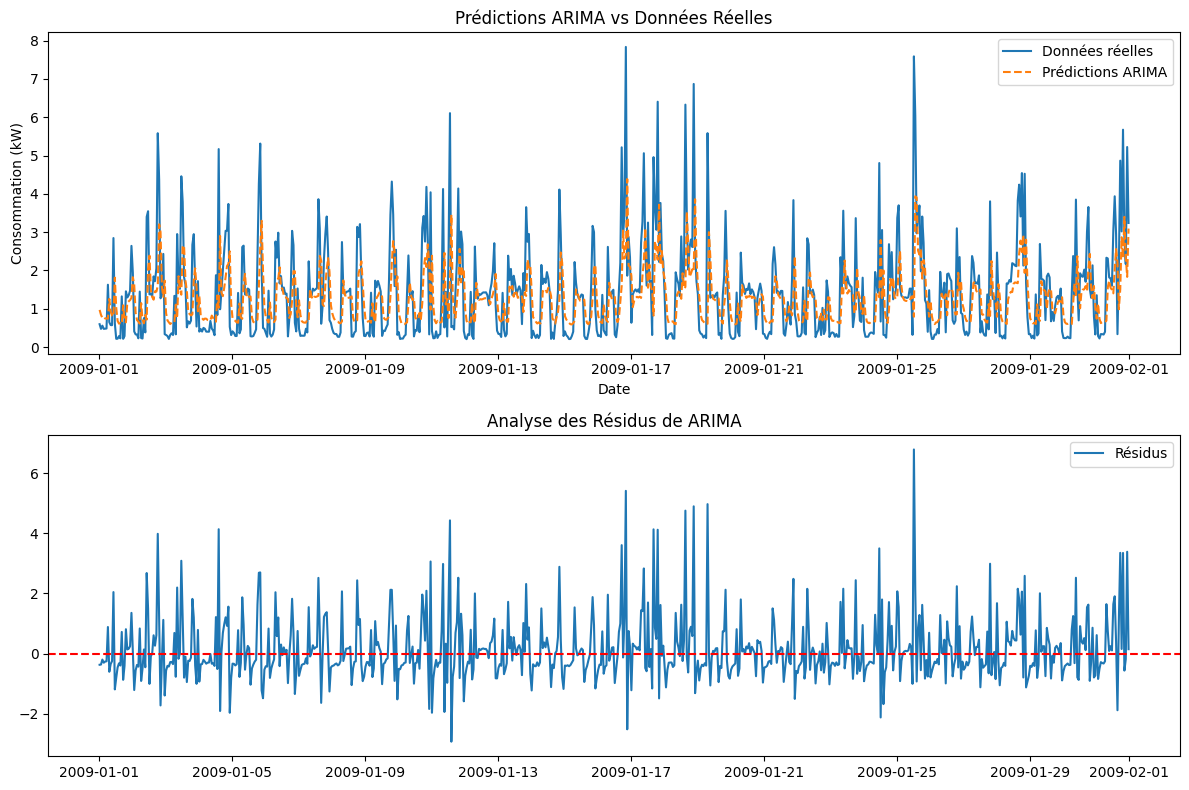

In [27]:
# Prédictions avec index correct

df.loc[:, 'forecast'] = model_fit.predict(start=df.index[0], end=df.index[-1])
df_janvier_2009 = df.loc["2009-01-01":"2009-01-31"].copy()


# Visualisation
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(df_janvier_2009['Global_active_power'], label="Données réelles")
plt.plot(df_janvier_2009['forecast'], label="Prédictions ARIMA", linestyle="dashed")
plt.title("Prédictions ARIMA vs Données Réelles")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()

plt.subplot(212)
residuals = df_janvier_2009['Global_active_power'] - df_janvier_2009['forecast']
plt.plot(df_janvier_2009.index, residuals, label="Résidus")
plt.axhline(0, linestyle='dashed', color='red')
plt.legend()
plt.title("Analyse des Résidus de ARIMA")
plt.tight_layout()
plt.show()


### **Analyse du Graphique : Prédictions ARIMA vs Données Réelles (Janvier 2009)**

L’image représente les **prédictions du modèle ARIMA** comparées aux **données réelles de consommation d’énergie** sur le mois de **janvier 2009**.


- ***Précision du Modèle***
    - **Les prédictions suivent globalement la tendance des données réelles**, indiquant que le modèle **captive bien les fluctuations de consommation**.  
    - **Le modèle réussit à suivre les pics et les creux**, bien que **certains écarts persistent**.


- ***Variabilité Temporelle***
    - **Le modèle capture les cycles journaliers de consommation**, montrant **une corrélation avec les variations horaires d’utilisation d’électricité**.  
    - **Cependant, certains pics sont sous-estimés ou surestimés**, ce qui **pourrait être amélioré en intégrant une meilleure prise en compte de la saisonnalité**.

### **Analyse des Résidus du Modèle ARIMA**

L’image montre **l’analyse des résidus du modèle ARIMA** appliqué à la **consommation d’énergie** en **janvier 2009**.

- ***Centrage autour de zéro***
    - **Les résidus fluctuent autour de la ligne rouge (moyenne nulle)**, ce qui est un bon indicateur que **le modèle ne présente pas de biais systématique**.  

- ***Présence de motifs dans les erreurs***  
    - **Une dispersion irrégulière est visible**, notamment avec **des pics importants**, indiquant que **le modèle ne capture pas parfaitement toutes les dynamiques de la série**.  
    - **Certains pics soudains de résidus** montrent **des erreurs plus marquées à certains moments**, suggérant que **des événements non modélisés influencent les prédictions**.

- ***Hétéroscédasticité potentielle***
    - **L’intensité des résidus semble varier par périodes**, ce qui pourrait **indiquer une variance non constante**.  
    - **Ce phénomène pourrait être mieux géré en intégrant un modèle GARCH** ou en **appliquant une transformation logarithmique aux données**.  


# **Évaluation du Modèle ARIMA**

Une fois le modèle entraîné, nous pouvons utiliser plusieurs **métriques** pour juger de sa pertinence :


- ***Erreur Absolue Moyenne (MAE)***

    L'**Erreur Absolue Moyenne** (**MAE**) mesure l'écart moyen absolu entre les **prédictions** et les **valeurs réelles** :

    $$
    MAE = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
    $$

    
    - **MAE faible** → Le modèle **prédit des valeurs proches des données réelles**.  
    - **MAE élevé** → Il y a **des écarts importants en moyenne** entre les prédictions et la réalité.


- ***Erreur Quadratique Moyenne (RMSE)***

    L'**Erreur Quadratique Moyenne** (**RMSE**) est une **mesure plus sensible aux grandes erreurs** :

    $$
    RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2}
    $$

    - **Le RMSE pénalise davantage les grandes erreurs**, ce qui permet de détecter si **le modèle est imprécis sur certaines valeurs extrêmes**.  
    - **Un RMSE proche du MAE** indique que **les erreurs sont bien réparties** et qu'il n'y a **pas de grandes erreurs isolées**.  

In [29]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
 
mae = mean_absolute_error(df['Global_active_power'], df['forecast'])
print(f"MAE: {mae}")

rmse = np.sqrt(mean_squared_error(df['Global_active_power'], df['forecast']))
print(f"RMSE: {rmse}")

MAE: 0.624258663279541
RMSE: 0.8964330812315603


Après l'entraînement du modèle, nous avons calculé les **métriques d'erreur** suivantes :

- ***Erreur Absolue Moyenne (MAE)***

    - **Le MAE indique que, en moyenne, les prévisions du modèle ARIMA s'écartent de 0.6242 kW des valeurs réelles.**  
    - **Un MAE faible** signifie que **le modèle est globalement précis**.


- ***Erreur Quadratique Moyenne (RMSE)***

    L'**Erreur Quadratique Moyenne** (**RMSE**) est définie comme suit :

    - **Le RMSE est plus sensible aux grandes erreurs** : la valeur de **0.8964 kW** suggère que **certaines prévisions présentent des écarts plus importants**.  
    - **Un RMSE supérieur au MAE** indique **que le modèle peine davantage à prédire les pics de consommation**.

## **Modèle SARIMA (Saisonality AutoRegressive Integrated Moving Average)**

- ***Équation générale***


$$
(1 - \sum_{i=1}^{p} \varphi_i L^i)(1 - \sum_{j=1}^{P} \Phi_j L^{js}) (1 - L)^d (1 - L^s)^D X_t
= (1 + \sum_{k=1}^{q} \theta_k L^k)(1 + \sum_{m=1}^{Q} \Theta_m L^{ms}) \epsilon_t
$$

$$
\Phi_P(L^s) \varphi_p(L) (1 - L)^d (1 - L^s)^D X_t =
\Theta_Q(L^s) \theta_q(L) \epsilon_t
$$

où :

- **$X_t$** : Série temporelle observée.
- **$L$** : Opérateur de retard (**$L X_t = X_{t-1}$**).
- **$d$** : Nombre de différenciations pour stationnariser la série.
- **$\varphi_p(L)$** et **$\Phi_P(L^s)$** : Polynômes de la partie **AutoRégressive (AR)**.
- **$\theta_q(L)$** et **$\Theta_Q(L^s)$** : Polynômes de la partie **Moyenne Mobile (MA)**.
- **$P, D, Q, s$** : Paramètres de la saisonnalité.
- **$\epsilon_t$** : Bruit blanc.

Le modèle **SARIMA** est utilisé lorsque les **données présentent une saisonnalité** mais **aucune variable explicative externe**.

- ***Modèle SARIMAX (SARIMA avec Variable Exogène)***

Le modèle **SARIMAX** est une **extension de SARIMA** qui inclut une **variable exogène $Z_t$** :

$$
(1 - \sum_{i=1}^{p} \varphi_i L^i)(1 - \sum_{j=1}^{P} \Phi_j L^{js}) (1 - L)^d (1 - L^s)^D X_t
= (1 + \sum_{k=1}^{q} \theta_k L^k)(1 + \sum_{m=1}^{Q} \Theta_m L^{ms}) \epsilon_t + \beta Z_t
$$

$$
\Phi_P(L^s) \varphi_p(L) (1 - L)^d (1 - L^s)^D X_t =
\Theta_Q(L^s) \theta_q(L) \epsilon_t + \beta Z_t
$$

où :

- **$Z_t$** : Variable(s) exogène(s) influençant $X_t$.
- **$\beta$** : Coefficient mesurant l'impact de la variable exogène.

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Définition du modèle SARIMA
model_sarima = SARIMAX(df['Global_active_power'],
                        order=(1,0,1), 
                        seasonal_order=(1,0,1,24))

# Entraînement du modèle
model_fit_sarima = model_sarima.fit()

# Afficher le résumé du modèle
model_fit_sarima.summary()



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29702D+00    |proj g|=  1.35151D-01


 This problem is unconstrained.



At iterate    5    f=  1.26458D+00    |proj g|=  1.49257D-02

At iterate   10    f=  1.24133D+00    |proj g|=  3.55065D-02

At iterate   15    f=  1.23696D+00    |proj g|=  6.94215D-02

At iterate   20    f=  1.23279D+00    |proj g|=  1.45131D-02

At iterate   25    f=  1.22997D+00    |proj g|=  1.18392D-03

At iterate   30    f=  1.22980D+00    |proj g|=  5.70956D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     46      1     0     0   9.083D-05   1.230D+00
  F =   1.2298041866297553     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                Global_active_power   No. Observations:                34588
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -42536.467
Date:                            Mon, 17 Mar 2025   AIC                          85082.934
Time:                                    22:57:50   BIC                          85125.191
Sample:                                12-16-2006   HQIC                         85096.402
                                     - 11-26-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6793      0.008     86.131      0.000       0.664       0.695
ma.L1         -0.3638      0.010    -37.428      0.000      -0.383      -0.345
ar.S.L24       0.9986      0.000   5040.812      0.000       0.998       0.999
ma.S.L24      -0.9527      0.001   -642.010      0.000      -0.956      -0.950
sigma2         0.6839      0.003    252.332      0.000       0.679       0.689
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):             78633.15
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             1.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### **Analyse des Résultats du Modèle SARIMAX(1,0,1)x(1,0,1,24)**

Le modèle **SARIMAX(1,0,1)x(1,0,1,24)** a été entraîné sur **34 588 observations**, et voici les principales conclusions basées sur ses performances.

- ***1Interprétation des Paramètres du Modèle***
    | **Paramètre**   | **Valeur**  | **Interprétation** |
    |----------------|------------|--------------------|
    | **AR(1)**      | 0.6793     | Influence modérée de la valeur précédente sur la prédiction. |
    | **MA(1)**      | -0.3638    | Impact négatif des erreurs passées sur la prédiction. |
    | **AR saisonnier (24h)** | 0.9986 | Forte dépendance avec la valeur **24 heures auparavant** (périodicité journalière). |
    | **MA saisonnier (24h)** | -0.9527 | Ajustement des erreurs pour capter la **saisonnalité**. |
    | **$\sigma^2$** | 0.6839     | **Variance des résidus**, indiquant la dispersion des erreurs du modèle. |

    - **La valeur très proche de 1 pour AR.S.L24 (0.9986) montre une saisonnalité journalière extrêmement forte**.
    - **L'effet des erreurs saisonnières (MA.S.L24 = -0.9527) est également significatif**, confirmant **une structure récurrente dans la série temporelle**.


- ***Critères d'Évaluation du Modèle***

    | **Critère**  | **Valeur** | **Interprétation** |
    |-------------|-----------|--------------------|
    | **AIC**     | 85 082.934 | **Plus l'AIC est faible, meilleur est le modèle**. |
    | **BIC**     | 85 125.191 | **Pénalise les modèles trop complexes**. |
    | **HQIC**    | 85 096.402 | **Variante de l'AIC prenant en compte la taille de l’échantillon**. |

    - **L'AIC est assez élevé**, suggérant qu'il pourrait être **possible d'améliorer le modèle** en **testant d'autres valeurs de $(p, d, q)$ et $(P, D, Q)$** pour optimiser davantage la performance.

- **Analyse des Statistiques de Résidus**

    | **Test**                      | **Valeur**  | **Interprétation** |
    |--------------------------------|------------|--------------------|
    | **Ljung-Box (L1) (Q)**         | 0.15       | Indique que **les erreurs sont bien réparties** (**pas de corrélation forte**).
    | **Prob(Q)**                    | 0.70       | **Une valeur > 0.05 signifie que le modèle capture bien la structure temporelle**. |
    | **Jarque-Bera (JB) Test**      | 78 633.15  | **Test de normalité des résidus** (**valeur élevée = non-normalité**).  |
    | **Prob(JB)**                   | 0.00       | **Confirme que les résidus ne suivent pas une distribution normale**.  |
    | **Hétéroscédasticité (H)**     | 0.68       | **Vérifie si la variance des erreurs est constante dans le temps**.  |
    | **Prob(H) (two-sided)**        | 0.00       | **Indique une légère variation de la variance des erreurs**.  |
    | **Skewness**                   | 1.74       | **Distribution des résidus légèrement asymétrique**.  |
    | **Kurtosis**                   | 9.51       | **Présence d’extrêmes dans les résidus (forte leptokurticité)**.  |

    - **La normalité des résidus n'est pas respectée** → **Le modèle ne capture pas toutes les variations de la série**.  
    - **Une forte kurtosis (9.51) montre qu’il existe des valeurs extrêmes non expliquées par le modèle**.  
    - **Le test de Ljung-Box (0.70) est satisfaisant**, indiquant que **les résidus sont indépendants**.   


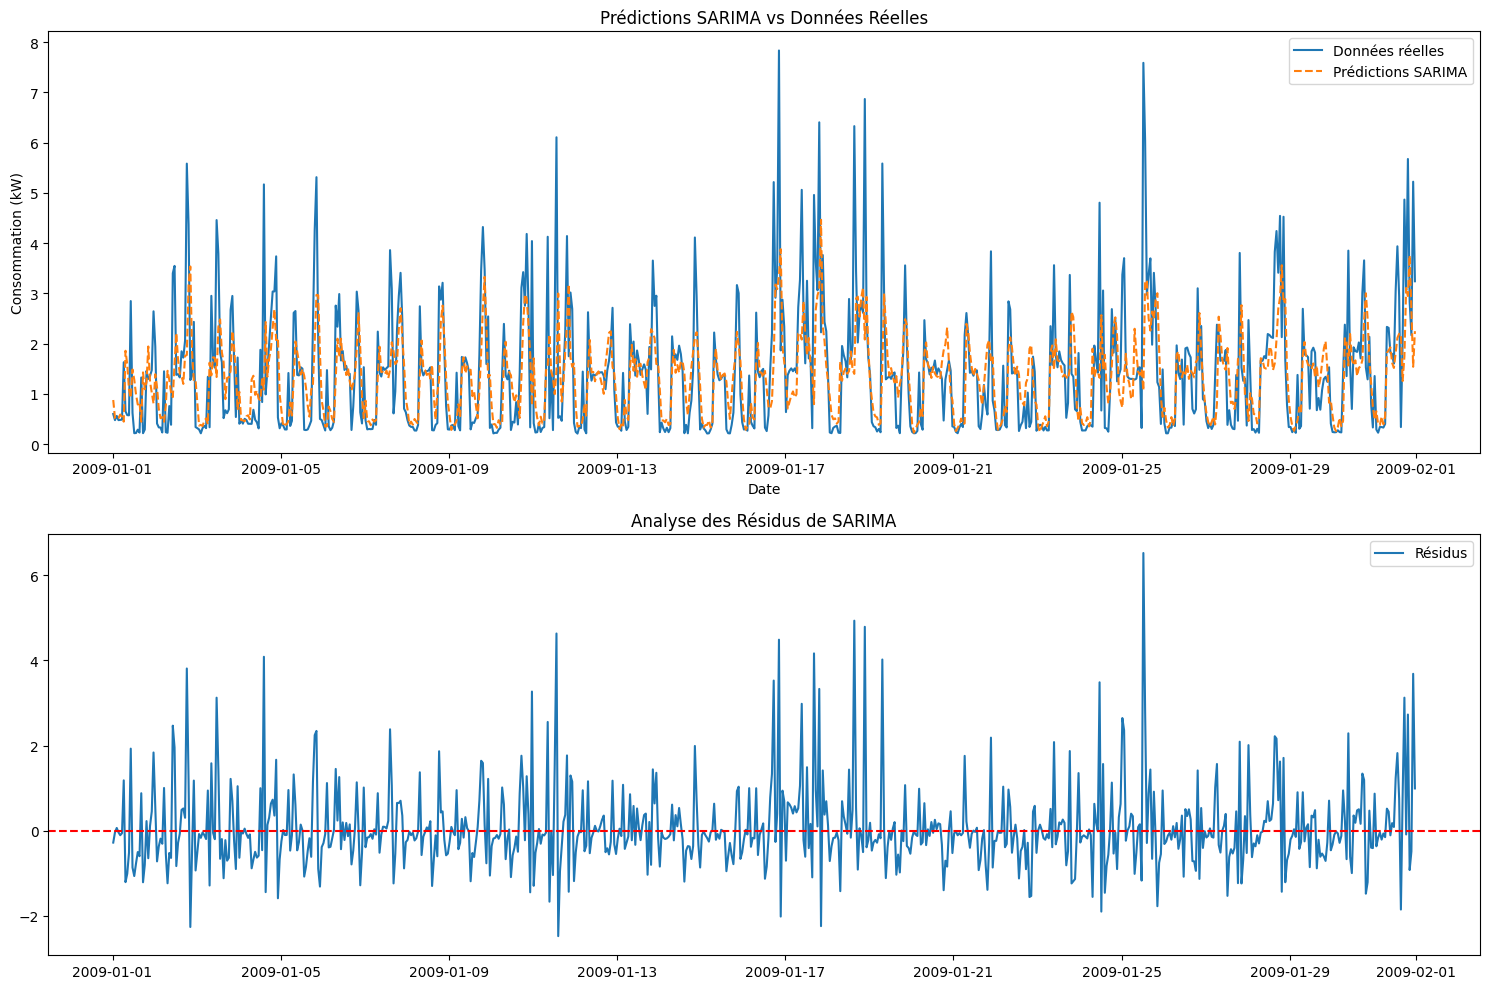

In [35]:
# Prédictions avec index correct
df.loc[:, 'forecast_sarima'] = model_fit_sarima.predict(start=df.index[0], end=df.index[-1])
df_janvier_2009 = df.loc["2009-01-01":"2009-01-31"].copy()

# Comparaison des prédictions SARIMA vs données réelles
plt.figure(figsize=(15,10))

plt.subplot(211)
plt.plot(df_janvier_2009['Global_active_power'], label="Données réelles")
plt.plot(df_janvier_2009['forecast_sarima'], label="Prédictions SARIMA", linestyle="dashed")
plt.title("Prédictions SARIMA vs Données Réelles")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()

plt.subplot(212)
residuals = df_janvier_2009['Global_active_power'] - df_janvier_2009['forecast_sarima']
plt.plot(df_janvier_2009.index, residuals, label="Résidus")
plt.axhline(0, linestyle='dashed', color='red')
plt.legend()
plt.title("Analyse des Résidus de SARIMA")
plt.tight_layout()
plt.show()

### **Analyse du Graphique : Prédictions SARIMA vs Données Réelles (Janvier 2009)**

Ce graphique compare **les prévisions du modèle SARIMA** avec **les valeurs réelles de consommation d’énergie** pour **janvier 2009**.


- ***Capture de la Tendance Générale***
    - **Le modèle SARIMA suit bien la dynamique de la consommation d'énergie**.  
    - **Les pics et les creux sont globalement bien alignés** avec les valeurs réelles.  

- **Variabilité et Fluctuations**
    - **Les cycles journaliers sont bien modélisés**, ce qui indique que **la composante saisonnière fonctionne correctement**.  
    - **Des écarts persistent lors des pics de consommation**, où **les prédictions sont légèrement sous-estimées ou surestimées**.  
    - **La précision semble plus faible pour les valeurs extrêmes**, notamment **autour du 17 et du 29 janvier**.

In [36]:
mae = mean_absolute_error(df['Global_active_power'], df['forecast_sarima'])
print(f"MAE: {mae}")

rmse = np.sqrt(mean_squared_error(df['Global_active_power'], df['forecast_sarima']))
print(f"RMSE: {rmse}")

MAE: 0.5510822924649718
RMSE: 0.8283266513817634


### **Évaluation des Performances du Modèle SARIMA**

Après l'entraînement du modèle, nous avons calculé les **métriques d'erreur** suivantes :

- ***Erreur Absolue Moyenne (MAE)***

    - **Le MAE indique que, en moyenne, les prévisions du modèle SARIMA s'écartent de 0.5511 kW des valeurs réelles.**  
    - **Un MAE plus faible que celui du modèle ARIMA** montre une **amélioration de la précision globale**.  

- ***Erreur Quadratique Moyenne (RMSE)***

    - **Le RMSE est plus sensible aux grandes erreurs** : la valeur de **0.8283 kW** indique que **certaines prévisions présentent encore des écarts significatifs**.  
    - **Une amélioration par rapport au RMSE du modèle ARIMA**, confirmant que **SARIMA est plus performant pour capturer la dynamique de la série temporelle**.  

In [34]:
from pmdarima import auto_arima

# Utiliser Auto-ARIMA pour trouver les meilleurs paramètres (p, d, q) et (P, D, Q, s)
df_janvier_2009 = df.loc["2009-01-01":"2009-01-31"].copy()
auto_model = auto_arima(df_janvier_2009['Global_active_power'],
                        seasonal=True, m=24,  # 24 car saisonnalité journalière
                        trace=True,  # Afficher le processus
                        error_action='ignore', suppress_warnings=True,
                        stepwise=True,
                        maxiter=1000) 

# Afficher les meilleurs paramètres trouvés
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=23.52 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=2422.903, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=2208.227, Time=2.15 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=2247.976, Time=1.17 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=3047.584, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=2222.690, Time=0.08 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=2201.493, Time=9.81 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=41.48 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=9.11 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=2323.290, Time=4.67 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=2193.135, Time=11.89 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=2202.109, Time=2.73 sec
 ARIMA(2,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=50.67 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=8.24 sec
 ARIMA(3,0,0)(2,0,0)[24] intercept   : A

### **Analyse des Résultats du Modèle SARIMAX(3,0,1)x(2,0,0,24)**

Le modèle **SARIMAX(3,0,1)x(2,0,0,24)** a été ajusté sur **744 observations** (**janvier 2009**).  
Voici les principales conclusions basées sur ses performances.

- ***Interprétation des Paramètres du Modèle***
    | **Paramètre**   | **Valeur**  | **Interprétation** |
    |----------------|------------|--------------------|
    | **Constante**      | 0.9401     | Niveau moyen de la consommation prédite. |
    | **AR(1)**         | -0.5329    | Influence négative de la valeur précédente. |
    | **AR(2)**         | 0.4201     | Influence positive de la valeur d’il y a deux périodes. |
    | **AR(3)**         | 0.1656     | Influence plus faible de la valeur d’il y a trois périodes. |
    | **MA(1)**         | 0.9011     | Influence des erreurs passées sur les prédictions. |
    | **AR saisonnier (24h)** | 0.1763 | **Faible impact** de la valeur **24 heures auparavant**. |
    | **AR saisonnier (48h)** | 0.1261 | **Impact encore plus faible** de la valeur **48 heures auparavant**. |
    | **$\sigma^2$** | 1.0775     | **Variance des résidus**, indiquant la dispersion des erreurs du modèle. |

    - **La valeur forte de MA(1) = 0.9011 montre que le modèle s’appuie fortement sur les erreurs passées**.  
    - **Les termes saisonniers (AR.S.L24 et AR.S.L48) ont un impact relativement faible**, ce qui suggère que **la saisonnalité pourrait être mieux modélisée avec un autre modèle**.  

- ***2Critères d'Évaluation du Modèle***
    | **Critère**  | **Valeur** | **Interprétation** |
    |-------------|-----------|--------------------|
    | **AIC**     | 2 184.843 | **Plus l'AIC est faible, meilleur est le modèle**. |
    | **BIC**     | 2 221.740 | **Pénalise les modèles trop complexes**. |
    | **HQIC**    | 2 199.066 | **Variante de l'AIC prenant en compte la taille de l’échantillon**. |

    - **L'AIC a été réduit par rapport aux précédents essais, ce qui montre une amélioration du modèle**.  
    - **Il est possible que d'autres configurations puissent encore mieux ajuster les données**.  

- ***Analyse des Statistiques de Résidus***
    | **Test**                      | **Valeur**  | **Interprétation** |
    |--------------------------------|------------|--------------------|
    | **Ljung-Box (L1) (Q)**         | 0.02       | **Indique que les erreurs sont bien réparties** (**pas de corrélation forte**). |
    | **Prob(Q)**                    | 0.89       | **Une valeur > 0.05 signifie que le modèle capture bien la structure temporelle**. |
    | **Jarque-Bera (JB) Test**      | 1404.53    | **Test de normalité des résidus** (**valeur élevée = non-normalité**). |
    | **Prob(JB)**                   | 0.00       | **Confirme que les résidus ne suivent pas une distribution normale**. 
    | **Hétéroscédasticité (H)**     | 1.22       | **Vérifie si la variance des erreurs est constante dans le temps**. |
    | **Prob(H) (two-sided)**        | 0.12       | **Indique une légère variation de la variance des erreurs**. |
    | **Skewness**                   | 1.78       | **Distribution des résidus légèrement asymétrique**. |
    | **Kurtosis**                   | 8.71       | **Présence d’extrêmes dans les résidus (forte leptokurticité)**. |

    - **La normalité des résidus n'est pas respectée** → **Le modèle ne capture pas toutes les variations de la série**.  
    - **Une forte kurtosis (8.71) montre qu’il existe des valeurs extrêmes non expliquées par le modèle**.  
    - **Le test de Ljung-Box (0.89) est satisfaisant**, indiquant que **les résidus sont indépendants**, ce qui **est un bon point**.   


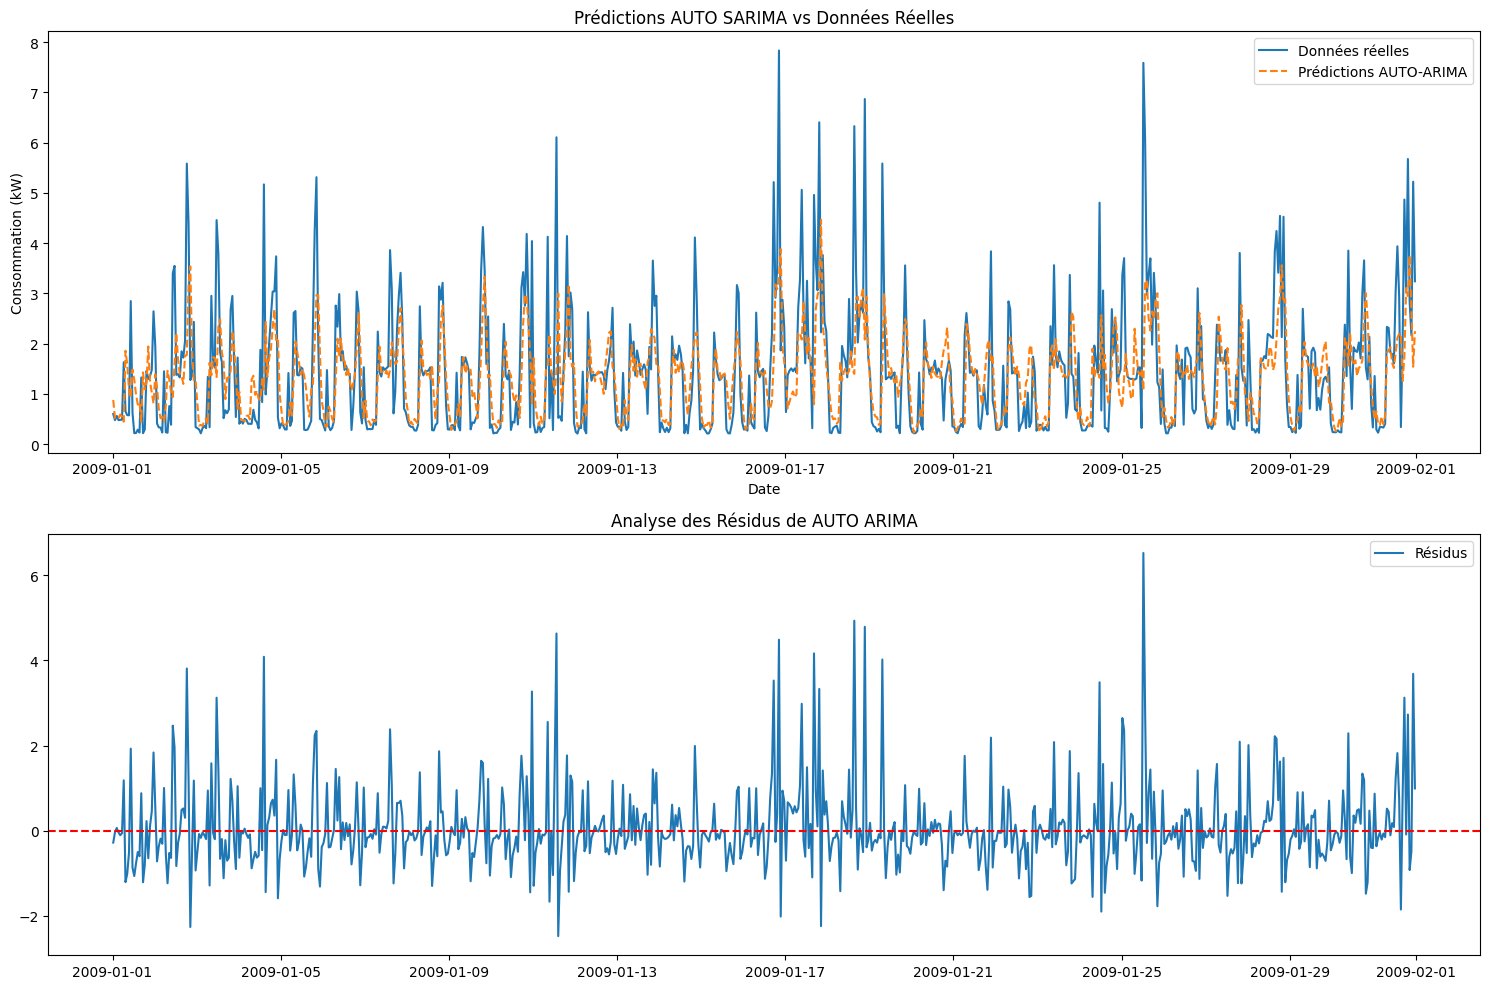

In [39]:
# Prédictions avec index correct
df_janvier_2009.loc[:, 'forecast_autosarima'] = model_fit_sarima.predict(start=df_janvier_2009.index[0], end=df_janvier_2009.index[-1])


# Comparaison des prédictions SARIMA vs données réelles
plt.figure(figsize=(15,10))

plt.subplot(211)
plt.plot(df_janvier_2009['Global_active_power'], label="Données réelles")
plt.plot(df_janvier_2009['forecast_sarima'], label="Prédictions AUTO-ARIMA", linestyle="dashed")
plt.title("Prédictions AUTO SARIMA vs Données Réelles")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()

plt.subplot(212)
residuals = df_janvier_2009['Global_active_power'] - df_janvier_2009['forecast_autosarima']
plt.plot(df_janvier_2009.index, residuals, label="Résidus")
plt.axhline(0, linestyle='dashed', color='red')
plt.legend()
plt.title("Analyse des Résidus de AUTO ARIMA")
plt.tight_layout()
plt.show()

A cause de la complexité du modele auto-arima, on a choisi 

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

exog_variables = df[['Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]

# Définition du modèle SARIMAX
sarimax_model = SARIMAX(df['Global_active_power'],
                        exog=exog_variables,
                        order=(1,0,1), seasonal_order=(1,0,1,24))

# Entraînement
sarimax_fit = sarimax_model.fit()

# Affichage des résultats
print(sarimax_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70533D+00    |proj g|=  5.90596D+00


 This problem is unconstrained.



At iterate    5    f= -1.70823D+00    |proj g|=  1.78480D-01

At iterate   10    f= -1.70824D+00    |proj g|=  3.88622D-02

At iterate   15    f= -1.70830D+00    |proj g|=  1.03615D+00

At iterate   20    f= -1.71097D+00    |proj g|=  2.61413D+00

At iterate   25    f= -1.71132D+00    |proj g|=  8.50801D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     27     69      2     0     0   1.122D-01  -1.711D+00
  F =  -1.7113197891246221     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                Global_active_power   No. Observations:                34588
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood               59191.129
Date:                            Tue, 18 Mar 2025   AIC                        -118364.258
Time:                                    00:41:21   BIC    

### **Analyse des Résultats du Modèle SARIMAX(1,0,1)x(1,0,1,24)**

Le modèle **SARIMAX(1,0,1)x(1,0,1,24)** a été ajusté sur **34 588 observations**.  
Son log-vraisemblance a atteint **59 191.129**, ce qui a conduit à :  
- **AIC = -118 364.258**  
- **BIC = -118 288.196**  
- **HQIC = -118 340.017**  

Ces valeurs indiquent **une amélioration significative par rapport aux modèles précédents**.

- ***Interprétation des Paramètres du Modèle***

    | **Paramètre**         | **Valeur**  | **Interprétation** |
    |----------------------|------------|--------------------|
    | **Global_intensity**  | 0.2322     | Influence directe sur la consommation. |
    | **Sub_metering_1**    | 0.0006     | **Faible impact** du premier sous-compteur. |
    | **Sub_metering_2**    | 0.0003     | **Très faible influence** du second sous-compteur. |
    | **Sub_metering_3**    | 0.0031     | **Influence notable** du troisième sous-compteur. |
    | **AR(1)**            | 0.8325     | **Forte dépendance** à la valeur précédente. |
    | **MA(1)**            | -0.7069    | **Correction importante** des erreurs précédentes. |
    | **AR saisonnier (24h)** | 0.8409 | **Fort effet des valeurs d’il y a 24 heures**. |
    | **MA saisonnier (24h)** | -0.7586 | **Ajustement significatif** des erreurs sur la saisonnalité. |
    | **$\sigma^2$**       | 0.0019     | **Très faible variance des erreurs**, ce qui est un bon signe. |

    - **Le terme AR(1) est très fort (0.8325)**, ce qui signifie que **la série temporelle dépend fortement de sa propre valeur passée**.
    - **Les termes saisonniers sont significatifs**, ce qui montre que **le modèle capture bien la répétition des schémas journaliers**.
    - **Les sous-compteurs ont un impact faible mais non négligeable**, suggérant qu’un modèle intégrant d'autres **variables exogènes** pourrait être intéressant.

- ***Critères d'Évaluation du Modèle***

| **Critère**  | **Valeur** | **Interprétation** |
|-------------|-----------|--------------------|
| **AIC**     | -118 364.258 | **Indique un bon ajustement du modèle**. |
| **BIC**     | -118 288.196 | **Pénalise la complexité, reste faible**. |
| **HQIC**    | -118 340.017 | **Variante de l’AIC prenant en compte la taille des données**. |

- **La forte réduction de l’AIC montre que ce modèle est plus performant que les précédents**.
- **Le BIC pénalise légèrement la complexité**, ce qui signifie que **l’ajout de paramètres supplémentaires n’améliore pas beaucoup le modèle**.

- ***Analyse des Résidus***

| **Test**                      | **Valeur**  | **Interprétation** |
|--------------------------------|------------|--------------------|
| **Ljung-Box (L1) (Q)**         | 1.07       | **Indique que les erreurs ne sont pas fortement corrélées**. |
| **Prob(Q)**                    | 0.30       | **Valeur > 0.05**, ce qui signifie que **les résidus sont proches d'un bruit blanc**. |
| **Jarque-Bera (JB) Test**      | 282 309.02 | **Test de normalité des résidus** (**valeur élevée = non-normalité**). |
| **Prob(JB)**                   | 0.00       | **Confirme que les résidus ne suivent pas une distribution normale**. |
| **Hétéroscédasticité (H)**     | 0.92       | **Légère variation de la variance des erreurs**. |
| **Prob(H) (two-sided)**        | 0.00       | **Indique une certaine instabilité dans la variance des erreurs**. |
| **Skewness**                   | -2.07      | **Indique une asymétrie des résidus** (décalés vers les valeurs négatives). |
| **Kurtosis**                   | 16.37      | **Très forte leptokurticité**, indiquant **de nombreux outliers**. |

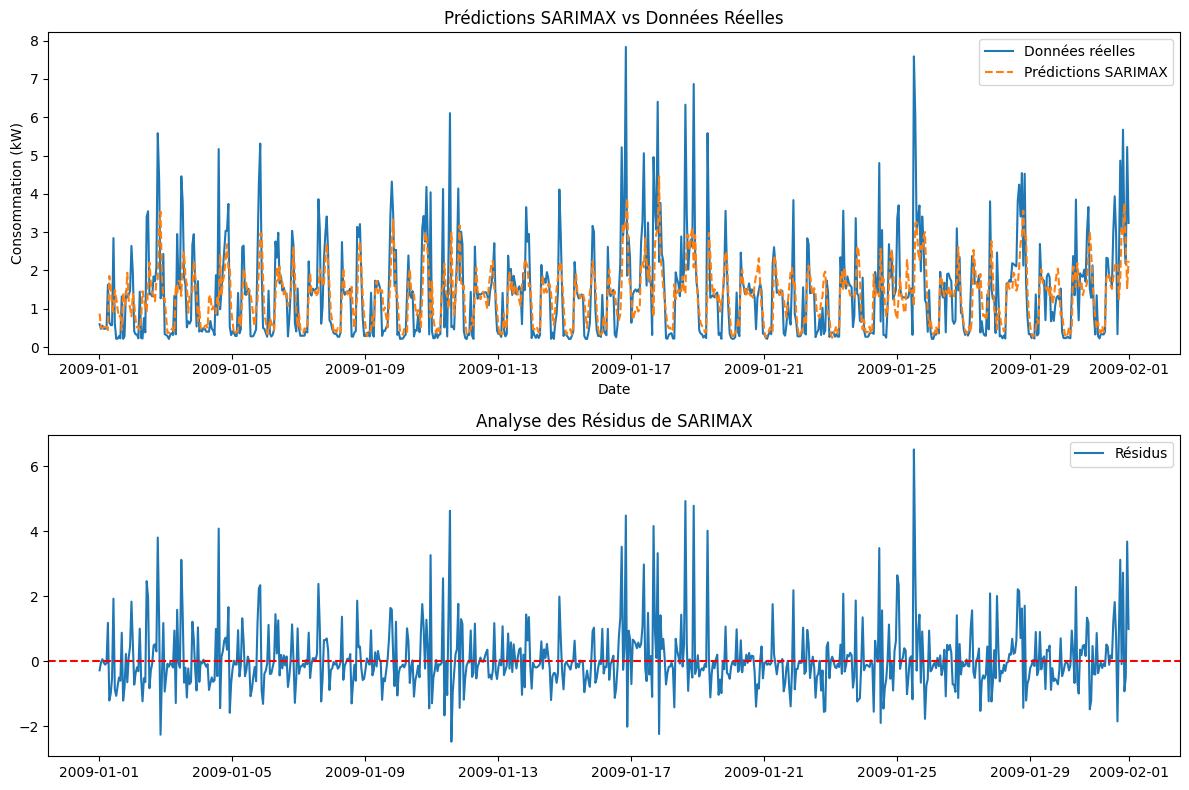

In [44]:
# Prédictions avec index correct
df.loc[:, 'forecast_sarimax'] = model_fit_sarima.predict(start=df.index[0], end=df.index[-1])
df_janvier_2009 = df.loc["2009-01-01":"2009-01-31"].copy()
residuals = df_janvier_2009['Global_active_power'] - df_janvier_2009['forecast_sarima']

# Comparaison des prédictions SARIMA vs données réelles
plt.figure(figsize=(12,8))

plt.subplot(2, 1, 1)
plt.plot(df_janvier_2009['Global_active_power'], label="Données réelles")
plt.plot(df_janvier_2009['forecast_sarimax'], label="Prédictions SARIMAX", linestyle="dashed")
plt.title("Prédictions SARIMAX vs Données Réelles")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_janvier_2009.index, residuals, label="Résidus")
plt.axhline(0, linestyle='dashed', color='red')
plt.legend()
plt.title("Analyse des Résidus de SARIMAX")

plt.tight_layout()
plt.show()

In [45]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(df['Global_active_power'], df['forecast_sarimax'])
print(f"MAE: {mae}")
rmse = np.sqrt(mean_squared_error(df['Global_active_power'], df['forecast_sarimax']))
print(f"RMSE: {rmse}")

MAE: 0.5510822924649718
RMSE: 0.8283266513817634


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [53]:
# Normalisation des données pour LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['Global_active_power']])
df_scaled.shape

(34588, 1)

In [55]:
# Creation des séquences temporelles
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i: i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [56]:
# Définition des paramètres
time_steps = 24  # Utiliser les 24 dernières heures pour prédire la suivante

# Séparation en train/test (80% train, 20% test)
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled[:train_size], df_scaled[train_size:]

# Création des séquences temporelles
X_train, y_train = create_sequences(train, time_steps)
X_test, y_test = create_sequences(test, time_steps)

# Reshape pour être compatible avec LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Shape de X_train :", X_train.shape)
print("Shape de X_test :", X_test.shape)


Shape de X_train : (27646, 24, 1)
Shape de X_test : (6894, 24, 1)


In [59]:

# Modèle LSTM amélioré
input_layer = Input(shape=(time_steps, 1))
x = LSTM(100, activation='relu', return_sequences=True)(input_layer)
x = Dropout(0.2)(x)
x = LSTM(100, activation='relu', return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(50, activation='relu')(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Entraînement
history = model.fit(X_train, y_train, epochs=30, batch_size=70, validation_data=(X_test, y_test), verbose=2, shuffle=False)


Epoch 1/30
395/395 - 16s - 41ms/step - loss: 0.0109 - val_loss: 0.0089
Epoch 2/30
395/395 - 6s - 16ms/step - loss: 0.0106 - val_loss: 0.0091
Epoch 3/30
395/395 - 6s - 16ms/step - loss: 0.0102 - val_loss: 0.0076
Epoch 4/30
395/395 - 6s - 16ms/step - loss: 0.0088 - val_loss: 0.0068
Epoch 5/30
395/395 - 6s - 16ms/step - loss: 0.0085 - val_loss: 0.0067
Epoch 6/30
395/395 - 6s - 16ms/step - loss: 0.0084 - val_loss: 0.0065
Epoch 7/30
395/395 - 6s - 16ms/step - loss: 0.0083 - val_loss: 0.0066
Epoch 8/30
395/395 - 6s - 16ms/step - loss: 0.0082 - val_loss: 0.0066
Epoch 9/30
395/395 - 6s - 16ms/step - loss: 0.0081 - val_loss: 0.0065
Epoch 10/30
395/395 - 6s - 16ms/step - loss: 0.0080 - val_loss: 0.0063
Epoch 11/30
395/395 - 6s - 16ms/step - loss: 0.0080 - val_loss: 0.0062
Epoch 12/30
395/395 - 6s - 16ms/step - loss: 0.0079 - val_loss: 0.0063
Epoch 13/30
395/395 - 6s - 16ms/step - loss: 0.0079 - val_loss: 0.0061
Epoch 14/30
395/395 - 6s - 16ms/step - loss: 0.0078 - val_loss: 0.0062
Epoch 15/30
39

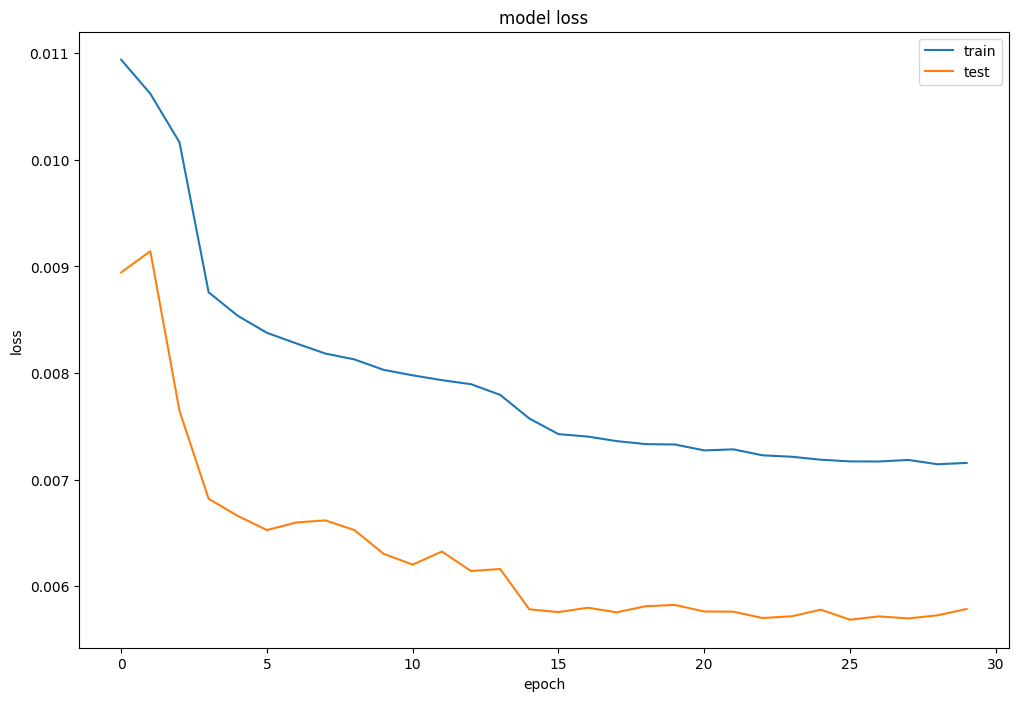

In [61]:
# summarize history for loss
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [62]:
# Prédictions avec LSTM
y_pred_lstm = model.predict(X_test)

# Dénormaliser les prédictions
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Ajouter au DataFrame pour comparer
df_results = pd.DataFrame({
    'Date': df.index[-len(y_test):],
    'Réel': y_test.flatten(),
    'Prédiction LSTM': y_pred_lstm.flatten(),
    'Prédiction ARIMA': df['forecast'].iloc[-len(y_test):].values,
    'Prédiction SARIMA': df['forecast_sarima'].iloc[-len(y_test):].values,
    'Prédiction SARIMAX': df['forecast_sarimax'].iloc[-len(y_test):].values
}).set_index('Date')

print(df_results.head())


216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
                      Réel  Prédiction LSTM  Prédiction ARIMA  \
Date                                                            
2010-02-12 15:24:00  1.392         1.320702          1.287431   
2010-02-12 16:24:00  1.468         1.376876          1.263989   
2010-02-12 17:24:00  1.352         1.965094          1.293127   
2010-02-12 18:24:00  0.598         2.451547          1.247263   
2010-02-12 19:24:00  1.168         1.967502          0.899910   

                     Prédiction SARIMA  Prédiction SARIMAX  
Date                                                        
2010-02-12 15:24:00           1.426993            1.426993  
2010-02-12 16:24:00           1.218848            1.218848  
2010-02-12 17:24:00           1.424407            1.424407  
2010-02-12 18:24:00           1.968019            1.968019  
2010-02-12 19:24:00           2.164109            2.164109  


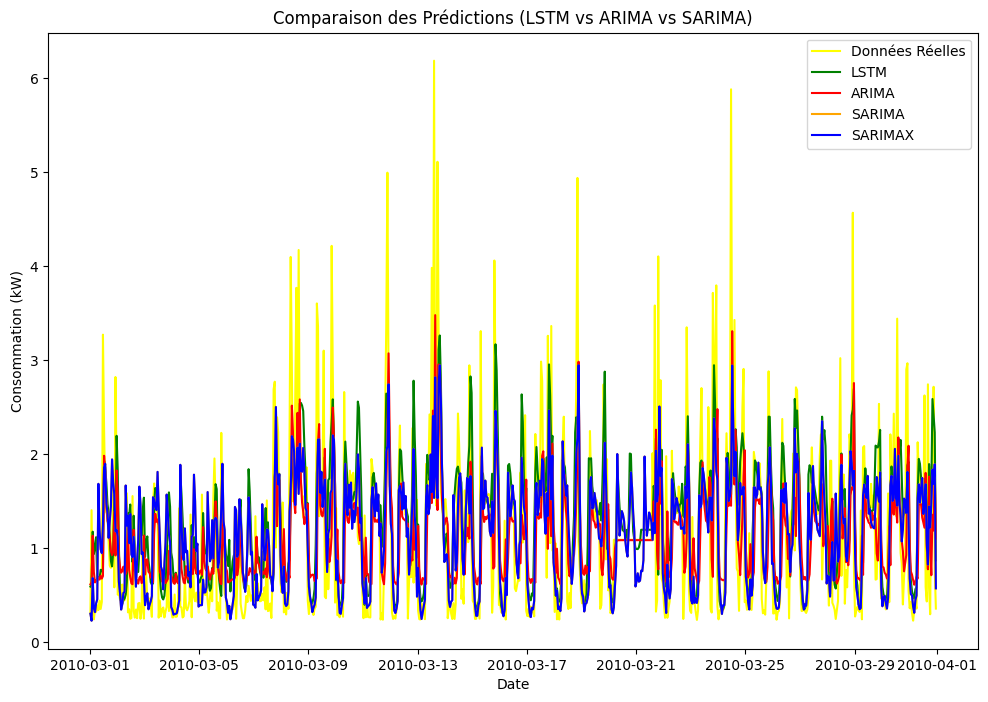

In [75]:
df_janvier_2010 = df_results.loc["2010-03-01":"2010-03-31"].copy()
plt.figure(figsize=(12,8))
sns.lineplot(data=df_janvier_2010, x='Date', y='Réel', label='Données Réelles', color='yellow')
sns.lineplot(data=df_janvier_2010, x='Date', y='Prédiction LSTM', label='LSTM', color='green')
sns.lineplot(data=df_janvier_2010, x='Date', y='Prédiction ARIMA', label='ARIMA', color='red')
sns.lineplot(data=df_janvier_2010, x='Date', y='Prédiction SARIMA', label='SARIMA', color='orange')
sns.lineplot(data=df_janvier_2010, x='Date', y='Prédiction SARIMAX', label='SARIMAX', color='blue')
plt.title("Comparaison des Prédictions (LSTM vs ARIMA vs SARIMA)")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()
plt.show()


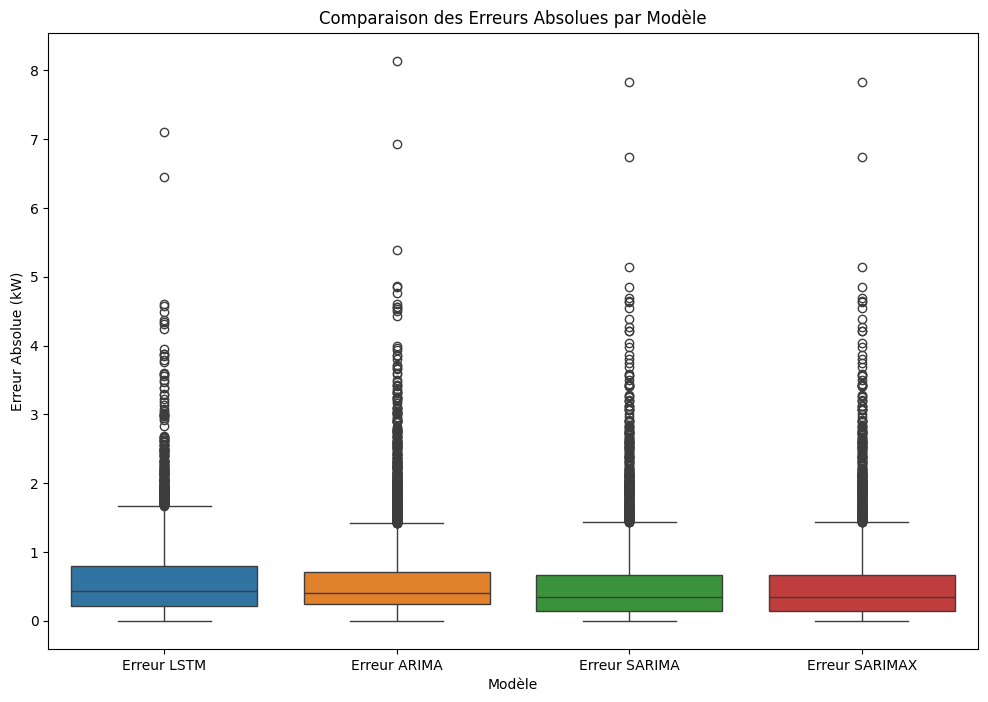

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des erreurs absolues
df_results["Erreur LSTM"] = abs(df_results["Réel"] - df_results["Prédiction LSTM"])
df_results["Erreur ARIMA"] = abs(df_results["Réel"] - df_results["Prédiction ARIMA"])
df_results["Erreur SARIMA"] = abs(df_results["Réel"] - df_results["Prédiction SARIMA"])
df_results["Erreur SARIMAX"] = abs(df_results["Réel"] - df_results["Prédiction SARIMAX"])

# Visualisation en boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_results[["Erreur LSTM", "Erreur ARIMA", "Erreur SARIMA", "Erreur SARIMAX"]])
plt.title("Comparaison des Erreurs Absolues par Modèle")
plt.ylabel("Erreur Absolue (kW)")
plt.xlabel("Modèle")
plt.show()


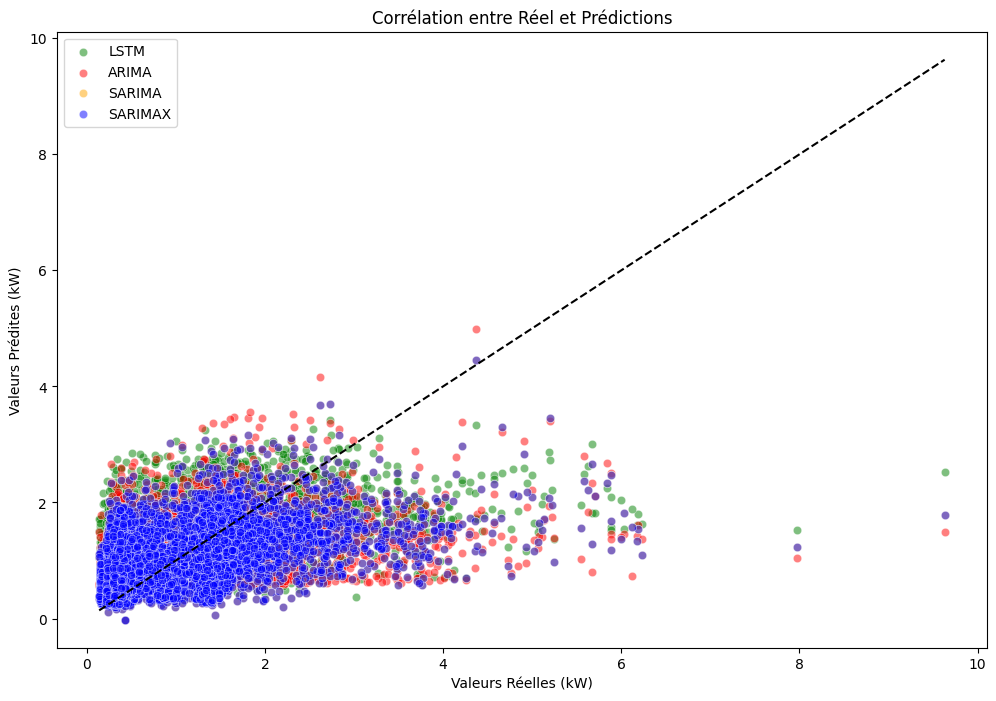

In [77]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df_results["Réel"], y=df_results["Prédiction LSTM"], label="LSTM", color="green", alpha=0.5)
sns.scatterplot(x=df_results["Réel"], y=df_results["Prédiction ARIMA"], label="ARIMA", color="red", alpha=0.5)
sns.scatterplot(x=df_results["Réel"], y=df_results["Prédiction SARIMA"], label="SARIMA", color="orange", alpha=0.5)
sns.scatterplot(x=df_results["Réel"], y=df_results["Prédiction SARIMAX"], label="SARIMAX", color="blue", alpha=0.5)
plt.plot([df_results["Réel"].min(), df_results["Réel"].max()], 
         [df_results["Réel"].min(), df_results["Réel"].max()], color="black", linestyle="dashed")  # Diagonale idéale
plt.xlabel("Valeurs Réelles (kW)")
plt.ylabel("Valeurs Prédites (kW)")
plt.title("Corrélation entre Réel et Prédictions")
plt.legend()
plt.show()


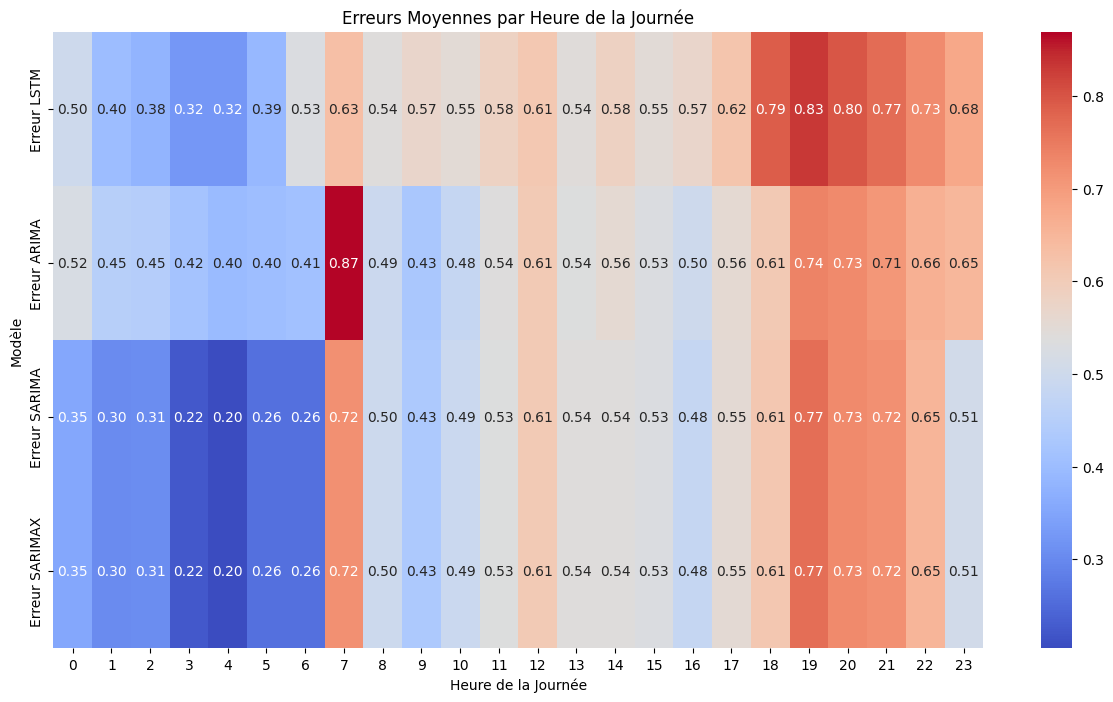

In [72]:
df_results["Heure"] = df_results.index.hour  # Extraire l'heure de la journée
df_errors = df_results.groupby("Heure")[["Erreur LSTM", "Erreur ARIMA", "Erreur SARIMA", "Erreur SARIMAX"]].mean()

plt.figure(figsize=(15, 8))
sns.heatmap(df_errors.T, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Erreurs Moyennes par Heure de la Journée")
plt.xlabel("Heure de la Journée")
plt.ylabel("Modèle")
plt.show()


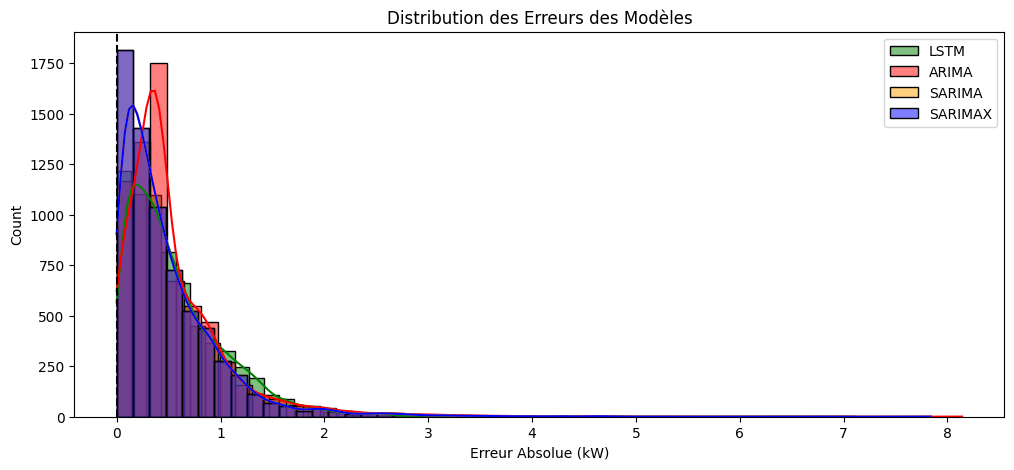

In [74]:
plt.figure(figsize=(12, 5))
sns.histplot(df_results["Erreur LSTM"], bins=50, label="LSTM", color="green", kde=True)
sns.histplot(df_results["Erreur ARIMA"], bins=50, label="ARIMA", color="red", kde=True)
sns.histplot(df_results["Erreur SARIMA"], bins=50, label="SARIMA", color="orange", kde=True)
sns.histplot(df_results["Erreur SARIMAX"], bins=50, label="SARIMAX", color="blue", kde=True)
plt.axvline(0, linestyle="dashed", color="black")  # Ligne zéro pour référence
plt.xlabel("Erreur Absolue (kW)")
plt.title("Distribution des Erreurs des Modèles")
plt.legend()
plt.show()
